# E-commerce — Выявление профилей потребления

# Задача:

Сегментировать покупателей по профилю потребления

* Проведите исследовательский анализ данных
* Сегментируйте покупателей на основе истории их покупок. Не бойтесь выдвигать собственные варианты сегментации покупателей. Задумайтесь о том как сегментация может помочь в разработке более персонализированных предложений для покупателей? Попробуйте сформировать сегменты на основе того, что покупают пользователи. Для этого вы можете проанализировать их покупки и сегментировать товары на основе принадлежности к той или иной товарной категории.
* Сформулируйте и проверьте статистические гипотезы

# Описание данных:

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки в  *ecommerce_dataset.csv* :

* `date` — дата заказа;
* `customer_id` — идентификатор покупателя;
* `order_id` — идентификатор заказа;
* `product` — наименование товара;
* `quantity` — количество товара в заказе;
* `price` — цена товара.

# Шаг 1. Выгрузка, изучение и предобработка данных

Выгрузим необходимые для работы библиотеки:

In [1]:
import pandas as pd
import numpy as np
from IPython import display

import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

import scipy.stats as stats
from scipy import stats as st

import matplotlib.pyplot as plt
from pymystem3 import Mystem
m = Mystem()
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import itertools
from statsmodels.stats.multitest import multipletests

Выгрузим данные из датасета:

In [2]:
google_id = "1DkqEQWZoHh22YrsYcNUxSzlhgFqdl0tf"
df_addon = pd.read_csv(f"https://drive.google.com/uc?export=download&id={google_id}" )

Выгрузим первые 5 строк датафрейма:

In [3]:
df_addon.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


Выгрузим общую информацию о датафрейме:

In [4]:
df_addon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


В датасете 7474 строки и 6 столбцов. Пропусков нет.

Приведем столбец с датой к типу datetime, с которым будет удобно работать дальше:

In [5]:
df_addon['date'] = pd.to_datetime(df_addon['date'], format='%Y%m%d%H')

Проверим результат:

In [6]:
df_addon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         7474 non-null   datetime64[ns]
 1   customer_id  7474 non-null   object        
 2   order_id     7474 non-null   int64         
 3   product      7474 non-null   object        
 4   quantity     7474 non-null   int64         
 5   price        7474 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 350.5+ KB


Все получилось. Типы данных остальных столбцов корректны и в изменении не нуждаются.

Проверим датасет на наличие дублей:

In [7]:
df_addon.duplicated().sum()

0

Дублей нет, все в порядке.

Предобработка датасета закончена:
* пропусков нет;
* дублей нет;
* тип данных с датой оформления заказа приведен к datetime.

# Шаг 2. Исследовательский анализ данных

Посчитаем число уникальных покупателей в датасете:

In [8]:
len(df_addon['customer_id'].unique())

2451

Посчитаем число уникальных заказов в датасете:

In [9]:
len(df_addon['order_id'].unique())

3521

Посчитаем число уникальных продуктов в датасете:

In [10]:
len(df_addon['product'].unique())

2343

Пока противоречий в данных нет: покупатели могут делать несколько заказов, в заказе может быть несколько товаров.

Посмотрим на распределение данных в датасете:

In [11]:
df_addon.describe()

,order_id,quantity,price
count,7474.000000,7474.000000,7474.000000
mean,49449.884265,2.362858,478.737501
std,32679.642404,14.500497,901.615895
min,12624.000000,1.000000,9.000000
25%,14833.000000,1.000000,97.000000
50%,68768.000000,1.000000,135.000000
75%,71257.750000,1.000000,439.000000
max,112789.000000,1000.000000,14917.000000


Среднее число товаров в заказе - 2,5 штуки (т.е. 2-3 штуки), средняя цена заказа - 478,74 уе.

В 75% заказов содержится всего 1 товар, его цена - не более 439 у.е.

Максимально число товаров в заказе - 1000 штук, стоимость - не более 14917 у.е.

# Изучим распределение по количеству покупаемых товаров

Построим гистограмму распределения по количеству покупаемых товаров:

Text(0, 0.5, 'Количество наблюдений')

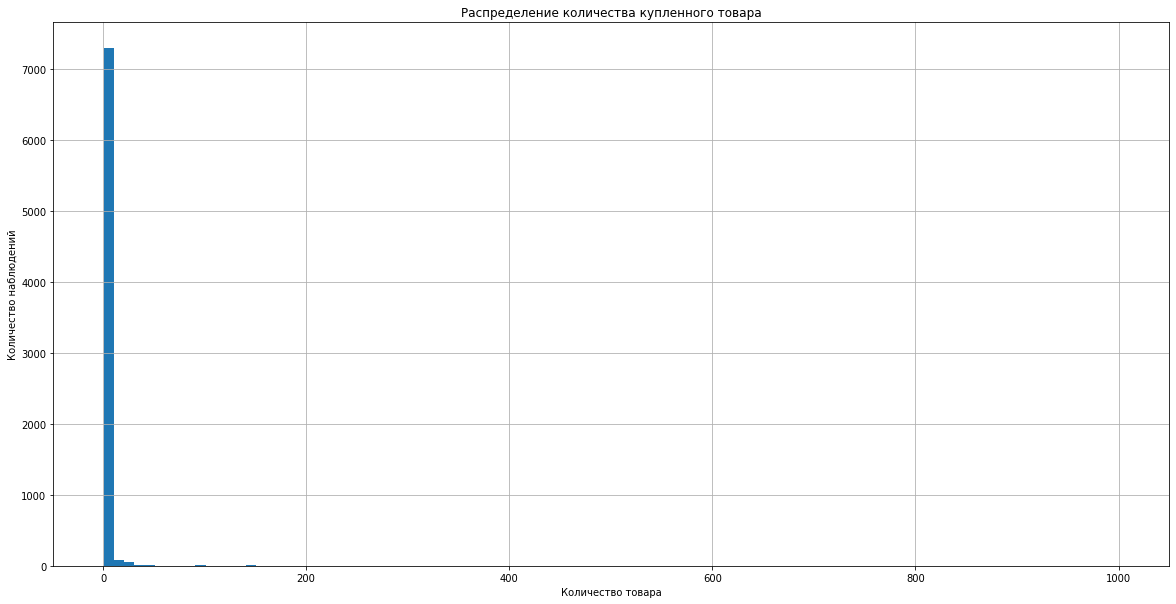

In [12]:
df_addon['quantity'].hist(bins=100, figsize=(20,10))
plt.title("Распределение количества купленного товара")
plt.xlabel("Количество товара")
plt.ylabel("Количество наблюдений")

На графике видно, что после 200 товаров плотность распределения практически нулевая. С другой стороны эти данные тоже могут быть интересны, поэтому просто так их отбрасывать не будем. Посмотрим, какие товары куплены в области от 900 товаров:

In [13]:
df_addon.query('quantity > 900')['product'].unique()

array(['Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000'],
      dtype=object)

Убираем этот заказ из датасета, т.к. он тестовый. Его удаление не повлияет отрицательно на точность исследования:

In [14]:
df_addon = df_addon.query('quantity <= 900')

Посмотрим на обновленное распределение данных в датасете:

In [15]:
df_addon.describe()

,order_id,quantity,price
count,7473.000000,7473.000000,7473.000000
mean,49446.901111,2.229359,478.711238
std,32680.811407,8.779149,901.673367
min,12624.000000,1.000000,9.000000
25%,14833.000000,1.000000,97.000000
50%,68768.000000,1.000000,135.000000
75%,71257.000000,1.000000,439.000000
max,112789.000000,334.000000,14917.000000


Теперь данные в датасете имеют бОльшую достоверность, например, среднее кол-во товаров в заказе вместо 2,5, показанных в начале, теперь равно 2,229 товарам.

# Изучим распределение по ценам купленных товаров

Построим гистограмму распределения по ценам купленных товаров:

Text(0, 0.5, 'Количество наблюдений')

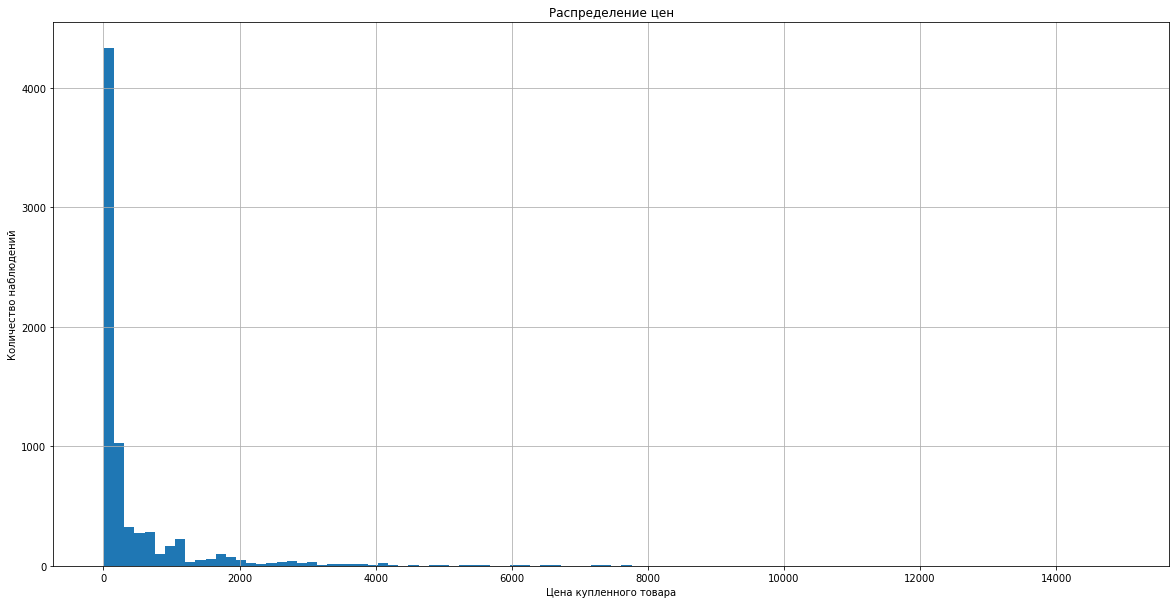

In [16]:
df_addon['price'].hist(bins=100, figsize=(20,10))
plt.title("Распределение цен")
plt.xlabel("Цена купленного товара")
plt.ylabel("Количество наблюдений")

На графике видно, что после стоимости товара более 8000 у.е. плотность распределения практически нулевая. Посмотрим, цены каких товаров встречаются в этой области:

In [17]:
df_addon.query('price > 8000')['product'].unique()

array(['Сумка-тележка хозяйственная Andersen Alu Star Shopper, Hava, синяя 115-103-90',
       'Сумка-тележка хозяйственная Andersen Royal Shopper, Hera, синяя 166-004-90',
       'Сумка-тележка хозяйственная Rolser MNB019 rojo LOGIC DOS+2 красная',
       'Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая'],
      dtype=object)

Судя по товарной номенклатуре, такие товары могут стоить своих денег, поэтому убирать их из датасета мы не будем, иначе рискуем потерять важную информацию.

Далее посмотрим, есть ли в датасете дубли заказов, т.к. заказы, у которых совпадают customer_id, order_id и product:

In [18]:
df_addon_dupl = df_addon[df_addon[['customer_id', 'order_id', 'product']].duplicated(keep = False)] # keep = False покажет все дубликаты
df_addon_dupl

,date,customer_id,order_id,product,quantity,price
15,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"Мини-сковорода Marmiton ""Сердце"" с антипригарн...",1,239.0
16,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,Сковорода алюминиевая с антипригарным покрытие...,1,824.0
17,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,Стеклянная крышка для сковороды ALPENKOK 26 см...,1,262.0
18,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"Сушилка для белья напольная Colombo Star 18, 3679",1,1049.0
19,2018-10-01 21:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
...,...,...,...,...,...,...
6716,2019-10-30 07:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6717,2019-10-30 09:00:00,344aa778-e436-419e-a9c6-9b8f37b7c1df,73137,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0


Выдает 2393 дублирующихся заказа. Посмотрим на них более внимательно:

In [19]:
df_addon_dupl.sort_values(by = 'customer_id', ascending = False).head(50)

,date,customer_id,order_id,product,quantity,price
1217,2018-12-15 23:00:00,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,69369,Новогоднее дерево Ель канадская Коника ртк 343...,1,389.0
1208,2018-12-14 23:00:00,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,69369,Новогоднее дерево Ель канадская Коника ртк 343...,1,389.0
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6716,2019-10-30 07:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
3589,2019-05-13 02:00:00,ff31d802-dae6-484d-a3dc-c9723f1cb538,71363,Стремянки Colombo Leonardo 2 ступени G300A02W ...,1,2999.0
3503,2019-05-10 03:00:00,ff31d802-dae6-484d-a3dc-c9723f1cb538,71363,Стремянки Colombo Leonardo 2 ступени G300A02W ...,1,2999.0
2755,2019-04-09 11:00:00,ff31d802-dae6-484d-a3dc-c9723f1cb538,71074,Стремянки Colombo Leonardo 2 ступени G300A02W ...,1,2999.0
2763,2019-04-10 03:00:00,ff31d802-dae6-484d-a3dc-c9723f1cb538,71074,Стремянки Colombo Leonardo 2 ступени G300A02W ...,1,2999.0
2764,2019-04-10 08:00:00,ff31d802-dae6-484d-a3dc-c9723f1cb538,71074,Стремянки Colombo Leonardo 2 ступени G300A02W ...,1,2999.0


Действительно, это полные дубли, которые различаются только датой или временем оформления заказа. Возможно, в датафрейм поступают данные по каждому изменению статуса заказа: например, "оформлен", "оплачен", "отправлен", "доставлен" и "получен". В любом случае, наличие таких полных дублей нам ни к чему. Отбросим из этой выборки первые заказы из каждого набора дублей, чтобы оценить масштабы дублирования заказов:

In [20]:
df_addon_dupl = df_addon[df_addon[['customer_id', 'order_id', 'product']].duplicated(keep = 'first')] # keep = 'first' покажет все дубликаты, кроме первого из каждого набора дублей
df_addon_dupl

,date,customer_id,order_id,product,quantity,price
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0
...,...,...,...,...,...,...
6706,2019-10-28 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0
6711,2019-10-28 21:00:00,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,Мирт d-9 см h-15 см,1,134.0
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0


Итого в датасете 1886 дублей заказов. Удалим их:

In [21]:
df_addon = df_addon[~df_addon[['customer_id', 'order_id', 'product']].duplicated()]
df_addon

,date,customer_id,order_id,product,quantity,price
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
...,...,...,...,...,...,...
7469,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт...,2,38.0
7470,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,Дендробиум Санок Анна Грин 1 ствол d-12 см,1,869.0
7471,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 ...,1,354.0
7472,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цве...,1,128.0


После удаления дублей заказов в датасете остались данные по 5587 заказам.

Посмотрим, не попадают ли у нас разные пользователи в одни и те же заказы:

In [22]:
df_addon.groupby('order_id').agg({'customer_id':'nunique'}).reset_index().query('customer_id > 1')

,order_id,customer_id
248,14872,2
516,68785,2
797,69283,2
817,69310,2
832,69345,2
862,69410,2
902,69485,3
933,69531,2
1066,69833,2
1200,70114,2


Таких пересечений много, посмотрим каждый набор и в случае полного совпадения удалим дубли:

In [23]:
df_addon.query('order_id == 14872')

,date,customer_id,order_id,product,quantity,price
5518,2019-06-21 22:00:00,4e861452-b692-48dc-b756-99a130b7a70a,14872,Однолетнее растение Петуния махровая в кассете...,2,82.0
5519,2019-06-21 22:00:00,4e861452-b692-48dc-b756-99a130b7a70a,14872,Однолетнее растение Петуния простая в кассете ...,1,82.0
5520,2019-06-21 22:00:00,4e861452-b692-48dc-b756-99a130b7a70a,14872,Петуния махровая рассада однолетних цветов в к...,1,128.0
5549,2019-06-24 09:00:00,9897ccd6-9441-4886-b709-b06361fabf6c,14872,Однолетнее растение Петуния махровая в кассете...,2,82.0
5550,2019-06-24 09:00:00,9897ccd6-9441-4886-b709-b06361fabf6c,14872,Однолетнее растение Петуния простая в кассете ...,1,82.0
5551,2019-06-24 09:00:00,9897ccd6-9441-4886-b709-b06361fabf6c,14872,Петуния махровая рассада однолетних цветов в к...,1,128.0


In [24]:
df_addon = df_addon.drop([5549, 5550, 5551]).reset_index(drop=True)

In [25]:
df_addon.query('order_id == 68785')

,date,customer_id,order_id,product,quantity,price
458,2018-10-28 22:00:00,0b5ce2c7-acef-4a9a-b821-61a44ed05557,68785,"Сиденье в ванну раздвижное, белый, СВ5, НИКА",1,374.0
470,2018-10-30 21:00:00,c1dd5c0e-51db-4a5d-91a3-5374cb20043d,68785,"Сиденье в ванну раздвижное, белый, СВ5, НИКА",1,374.0


In [26]:
df_addon = df_addon.drop([470]).reset_index(drop=True)

In [27]:
df_addon.query('order_id == 69283')

,date,customer_id,order_id,product,quantity,price
1010,2018-12-10 12:00:00,2f955596-4b13-432e-93f3-6433395aafe6,69283,Сушилка для белья на батарею НИКА СБ6-65 двухъ...,1,164.0
1015,2018-12-10 16:00:00,e3805ccd-2d64-4d0e-92dd-902293555c35,69283,Сушилка для белья на батарею НИКА СБ6-65 двухъ...,1,164.0


In [28]:
df_addon = df_addon.drop([1015]).reset_index(drop=True)

In [29]:
df_addon.query('order_id == 69310')

,date,customer_id,order_id,product,quantity,price
1030,2018-12-11 21:00:00,954172a5-634c-4a50-941d-9db6d15a7377,69310,"Муляж Груша желтый 9,5 см полиуретан",7,59.0
1432,2019-02-03 22:00:00,845d52ce-9420-4c44-b4b5-3fb55c792084,69310,"Муляж Груша желтый 9,5 см полиуретан",7,59.0


In [30]:
df_addon = df_addon.drop([1432]).reset_index(drop=True)

In [31]:
df_addon.query('order_id == 69345')

,date,customer_id,order_id,product,quantity,price
1047,2018-12-13 19:00:00,70d60304-4b3c-4f34-9430-1872ec6e6309,69345,Сушилка для белья Attribute ПРИМА 18 м синяя A...,1,974.0
1058,2018-12-15 07:00:00,22e4d79f-3613-4c22-8b01-7f880120bf5a,69345,Сушилка для белья Attribute ПРИМА 18 м синяя A...,1,974.0


In [32]:
df_addon = df_addon.drop([1058]).reset_index(drop=True)

In [33]:
df_addon.query('order_id == 69410')

,date,customer_id,order_id,product,quantity,price
1078,2018-12-17 14:00:00,4ea06f66-0876-4dec-8d14-ea994ffe435f,69410,Муляж Желудь 2 шт,3,22.0
1096,2018-12-18 20:00:00,caaa3f41-c9ab-4e3d-8b75-94e1d3a8d7b4,69410,Муляж Желудь 2 шт,3,22.0


In [34]:
df_addon = df_addon.drop([1096]).reset_index(drop=True)

In [35]:
df_addon.query('order_id == 69485')

,date,customer_id,order_id,product,quantity,price
1117,2018-12-20 16:00:00,5be0f4b4-947f-4672-b147-73ef5936ecd4,69485,Набор столовых приборов 24 предмета SAINT GERM...,1,1087.0
1126,2018-12-21 11:00:00,266beb08-ec9b-43b4-89bb-ac60fa23ffee,69485,Набор столовых приборов 24 предмета FARANDOLE ...,1,1274.0
1194,2018-12-26 23:00:00,e0461045-4fcc-4731-8837-509f6534512a,69485,Набор столовых приборов 24 предмета FARANDOLE ...,1,1274.0


In [36]:
df_addon = df_addon.drop([1126, 1194]).reset_index(drop=True)

In [37]:
df_addon.query('order_id == 69531')

,date,customer_id,order_id,product,quantity,price
1148,2018-12-23 14:00:00,e382d4c4-a4c9-44d3-97a0-a8868e122563,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo...,1,4139.0
1240,2019-01-07 09:00:00,2273b174-e223-415a-9be1-49d19abea06e,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo...,1,4139.0


In [38]:
df_addon = df_addon.drop([1241]).reset_index(drop=True)

In [39]:
df_addon.query('order_id == 69833')

,date,customer_id,order_id,product,quantity,price
1296,2019-01-15 17:00:00,631c5729-d163-4270-8956-4d9832085d0e,69833,Чехол Eurogold Clean Metallic металлизированый...,2,299.0
1353,2019-01-23 19:00:00,a684bf62-f75c-4e82-aa74-6d02b127b439,69833,Чехол Eurogold Clean Metallic металлизированый...,2,299.0


In [40]:
df_addon = df_addon.drop([1353]).reset_index(drop=True)

In [41]:
df_addon.query('order_id == 70114')

,date,customer_id,order_id,product,quantity,price
1455,2019-02-05 20:00:00,673d44a3-9cec-4c2f-b0c6-9be4952ddc7c,70114,Вешалка-плечики без эссенции цвет тёмно-розовы...,30,40.0
1508,2019-02-09 20:00:00,b827d1a8-5e5d-4a44-9813-2bd669471a73,70114,Вешалка-плечики без эссенции цвет тёмно-розовы...,30,40.0


In [42]:
df_addon = df_addon.drop([1509]).reset_index(drop=True)

In [43]:
df_addon.query('order_id == 70542')

,date,customer_id,order_id,product,quantity,price
1808,2019-03-01 19:00:00,b883aae0-25ef-4c5c-8d35-4c6ae8517f1c,70542,Миксер электрический погружной DELTA DL-5061 б...,1,959.0
1944,2019-03-10 22:00:00,00c95d20-923e-4b45-88fc-53b12931d462,70542,Миксер электрический погружной DELTA DL-5061 б...,1,959.0


In [44]:
df_addon = df_addon.drop([1945]).reset_index(drop=True)

In [45]:
df_addon.query('order_id == 70631')

,date,customer_id,order_id,product,quantity,price
1892,2019-03-06 13:00:00,411ab440-0631-422d-9999-8d5ef8cec0e2,70631,Искусственная композиция из цветов пластиковая...,1,74.0
1902,2019-03-07 07:00:00,d1bf7700-6afa-4297-9220-48e6aa0d7e2c,70631,Искусственная композиция из цветов пластиковая...,1,74.0


In [46]:
df_addon = df_addon.drop([1903]).reset_index(drop=True)

In [47]:
df_addon.query('order_id == 70726')

,date,customer_id,order_id,product,quantity,price
1977,2019-03-14 05:00:00,af96cc67-1726-43ba-bca1-1da7b78cb33a,70726,Пеларгония розебудная Red Pandora укорененный ...,2,134.0
1978,2019-03-14 07:00:00,95d61179-404e-4ebd-9762-29d800b1583e,70726,Пеларгония розебудная Red Pandora укорененный ...,2,134.0


In [48]:
df_addon = df_addon.drop([1979]).reset_index(drop=True)

In [49]:
df_addon.query('order_id == 70808')

,date,customer_id,order_id,product,quantity,price
2043,2019-03-20 15:00:00,78e8c0e7-4888-4a75-8137-a90f02a6cb8c,70808,Тележка багажная DELTA ТБР-20 черный с серым г...,1,727.0
2044,2019-03-20 16:00:00,ad1630b2-fc36-4961-900a-46612ff6c655,70808,Тележка багажная DELTA ТБР-20 черный с серым г...,1,727.0


In [50]:
df_addon = df_addon.drop([2045]).reset_index(drop=True)

In [51]:
df_addon.query('order_id == 70903')

,date,customer_id,order_id,product,quantity,price
2114,2019-03-28 10:00:00,5e5a3e1a-0388-4131-a770-f6e3b696985b,70903,Средство против засоров в системах водопровода...,1,104.0
2854,2019-05-01 01:00:00,718316fc-bdf3-4d1d-b8f1-a5c763238ff4,70903,Средство против засоров в системах водопровода...,1,142.0


In [52]:
df_addon = df_addon.drop([2855]).reset_index(drop=True)

In [53]:
df_addon.query('order_id == 70946')

,date,customer_id,order_id,product,quantity,price
2178,2019-04-01 09:00:00,6a4d397b-8f89-4382-89b3-9ef535eee80d,70946,Пеларгония розебудная Prins Nikolai укорененны...,1,134.0
2959,2019-05-08 16:00:00,753660bf-a1ea-4447-853d-622e47c1c6ac,70946,Пеларгония розебудная Prins Nikolai укорененны...,1,134.0


In [54]:
df_addon = df_addon.drop([2960]).reset_index(drop=True)

In [55]:
df_addon.query('order_id == 71054')

,date,customer_id,order_id,product,quantity,price
2309,2019-04-07 19:00:00,d713f977-a28f-4c34-ae9a-d132068e64f3,71054,Вешалка-плечики без эссенции цвет тёмно-розовы...,10,43.0
3683,2019-06-05 09:00:00,34572907-a445-4b40-b1b6-fd0cbfa653b1,71054,Вешалка-плечики без эссенции цвет тёмно-розовы...,10,43.0


In [56]:
df_addon = df_addon.drop([3684]).reset_index(drop=True)

In [57]:
df_addon.query('order_id == 71226')

,date,customer_id,order_id,product,quantity,price
2539,2019-04-21 15:00:00,c912fec9-fd4f-41b7-bb04-4548740b276b,71226,Сушилка для белья напольная НИКА СБ3Б 10 м белая,1,569.0
2541,2019-04-21 19:00:00,fd4af93f-9fbd-449f-91f8-b42b830e265b,71226,Сушилка для белья напольная НИКА СБ3Б 10 м белая,1,569.0


In [58]:
df_addon = df_addon.drop([2542]).reset_index(drop=True)

In [59]:
df_addon.query('order_id == 71461')

,date,customer_id,order_id,product,quantity,price
3338,2019-05-19 19:00:00,79162ad6-b2f0-491a-b3fb-2376c9001b63,71461,"Коврик придверный с дизайном, из резины и коко...",1,1642.0
3343,2019-05-20 08:00:00,9ecc5887-b4d4-4cea-b446-88748df71d9c,71461,"Коврик придверный с дизайном, из резины и коко...",1,1642.0


In [60]:
df_addon = df_addon.drop([3344]).reset_index(drop=True)

In [61]:
df_addon.query('order_id == 71480')

,date,customer_id,order_id,product,quantity,price
3366,2019-05-21 02:00:00,4bd9c1e8-b2cc-4ec5-97eb-28d8f3c22d8d,71480,Мята перечная Шоколадная Chocolate d-7 см h-10...,1,74.0
3421,2019-05-24 22:00:00,d8080f8f-3685-433b-b416-beb0a8f06606,71480,Мята перечная Шоколадная Chocolate d-7 см h-10...,1,74.0
3422,2019-05-25 02:00:00,51f04abe-a71a-4694-87b7-ad9ef4930e51,71480,Мята перечная Шоколадная Chocolate d-7 см h-10...,1,74.0


In [62]:
df_addon = df_addon.drop([3422, 3423]).reset_index(drop=True)

In [63]:
df_addon.query('order_id == 71542')

,date,customer_id,order_id,product,quantity,price
3481,2019-05-28 21:00:00,5ee242e4-7610-43bc-88a6-6ae2d886797f,71542,Салатник Luminarc КУТЮР 27 см H3529,1,299.0
4233,2019-08-07 10:00:00,52ca850d-ce65-4445-bddc-b0b063b13ba7,71542,Салатник Luminarc КУТЮР 27 см H3529,1,299.0


In [64]:
df_addon = df_addon.drop([4234]).reset_index(drop=True)

In [65]:
df_addon.query('order_id == 71571')

,date,customer_id,order_id,product,quantity,price
3589,2019-06-02 10:00:00,f1222eaa-d09d-4bff-ab4e-bea6fe3f68a8,71571,"Бегония Элатиор, цвет в ассортименте",1,187.0
3590,2019-06-02 10:00:00,95872093-2887-4ce8-8468-19234990e7d7,71571,"Бегония Элатиор, цвет в ассортименте",1,187.0


In [66]:
df_addon = df_addon.drop([3591]).reset_index(drop=True)

In [67]:
df_addon.query('order_id == 71648')

,date,customer_id,order_id,product,quantity,price
3712,2019-06-09 07:00:00,6921ac3e-bfcd-4a05-95d3-12ef81e874cc,71648,Сушилка для белья потолочная ЛИАНА ЛЮКС 250 см...,1,704.0
3770,2019-06-15 14:00:00,a843e87d-c9b8-475a-96fb-1edcccca5f8e,71648,Сушилка для белья потолочная ЛИАНА ЛЮКС 250 см...,1,704.0


In [68]:
df_addon = df_addon.drop([3771]).reset_index(drop=True)

In [69]:
df_addon.query('order_id == 71663')

,date,customer_id,order_id,product,quantity,price
3726,2019-06-10 13:00:00,11a9ee7f-c1af-48eb-ab82-bfe5dbc0ab02,71663,Пеларгония розебудная Prins Nikolai укорененны...,1,134.0
4409,2019-09-05 12:00:00,a7ef9c85-57e1-45ad-89c9-8b405339d4c8,71663,Пеларгония розебудная Prins Nikolai укорененны...,1,134.0


In [70]:
df_addon = df_addon.drop([4410]).reset_index(drop=True)

In [71]:
df_addon.query('order_id == 72188')

,date,customer_id,order_id,product,quantity,price
4197,2019-08-02 15:00:00,da6f7bf7-f699-4046-a4dd-cab0c27debcb,72188,Муляж Персики мини полиуретан d-6 см,1,22.0
4200,2019-08-03 13:00:00,55b8d928-77f8-40fc-a2e9-08424d13b0e4,72188,Муляж Персики мини полиуретан d-6 см,1,22.0


In [72]:
df_addon = df_addon.drop([4201]).reset_index(drop=True)

In [73]:
df_addon.query('order_id == 72778')

,date,customer_id,order_id,product,quantity,price
4564,2019-09-27 00:00:00,9777b839-4212-41bb-94c2-87de3658248a,72778,Шеффлера Голд Капелла d-12 см h-25 см,1,149.0
4686,2019-10-10 22:00:00,31a39955-8a93-42f3-8839-04a9693632a7,72778,Шеффлера Голд Капелла d-12 см h-25 см,1,149.0


In [74]:
df_addon = df_addon.drop([4687]).reset_index(drop=True)

In [75]:
df_addon.query('order_id == 72790')

,date,customer_id,order_id,product,quantity,price
4571,2019-09-28 10:00:00,a3d7fb5c-d3fb-40d6-b060-47a7061ca442,72790,Сушилка для белья потолочно-настенная Gimi Lif...,1,1424.0
4596,2019-09-30 09:00:00,07b63f16-aa4a-4acc-a7a5-af941fd4b0a9,72790,Сушилка для белья потолочно-настенная Gimi Lif...,1,1424.0


In [76]:
df_addon = df_addon.drop([4597]).reset_index(drop=True)

In [77]:
df_addon.query('order_id == 72845')

,date,customer_id,order_id,product,quantity,price
4621,2019-10-03 14:00:00,d8465f63-35db-4809-aff3-a8f7ebfc257f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
4622,2019-10-03 15:00:00,0309d37c-ab5f-4793-ba72-5484c019b840,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
4624,2019-10-04 08:00:00,25a8cd52-3efa-48ee-a6bd-d413d7e2b42f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
4650,2019-10-07 20:00:00,2ac05362-3ca7-4d19-899c-7ba266902611,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0


In [78]:
df_addon = df_addon.drop([4623, 4625, 4651]).reset_index(drop=True)

In [79]:
df_addon.query('order_id == 72950')

,date,customer_id,order_id,product,quantity,price
4700,2019-10-13 15:00:00,b1dbc7c4-3c84-40a7-80c9-46e2f79d24ad,72950,Кастрюля эмалированная Стэма С-1624 12 л цилин...,1,974.0
4705,2019-10-14 09:00:00,2f1671cc-47eb-49bb-a40b-808375f4218b,72950,Кастрюля эмалированная Стэма С-1624 12 л цилин...,1,974.0


In [80]:
df_addon = df_addon.drop([4706]).reset_index(drop=True)

Дубли удалил, проверим все еще раз:

In [81]:
df_addon.groupby('order_id').agg({'customer_id':'nunique'}).reset_index().query('customer_id > 1')

,order_id,customer_id
932,69531,2
1198,70114,2
1441,70542,2
1493,70631,2
1538,70726,2
1576,70808,2
1625,70903,2
1645,70946,2
1706,71054,2
1793,71226,2


Пересечения еще есть, посмотрим каждый набор и в случае полного совпадения также удалим дубли:

In [82]:
df_addon.query('order_id == 69531')

,date,customer_id,order_id,product,quantity,price
1148,2018-12-23 14:00:00,e382d4c4-a4c9-44d3-97a0-a8868e122563,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo...,1,4139.0
1240,2019-01-07 09:00:00,2273b174-e223-415a-9be1-49d19abea06e,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo...,1,4139.0


In [83]:
df_addon = df_addon.drop([1240]).reset_index(drop=True)

In [84]:
df_addon.query('order_id == 69833')

,date,customer_id,order_id,product,quantity,price
1295,2019-01-15 17:00:00,631c5729-d163-4270-8956-4d9832085d0e,69833,Чехол Eurogold Clean Metallic металлизированый...,2,299.0


In [85]:
df_addon = df_addon.drop([1240]).reset_index(drop=True)

In [86]:
df_addon.query('order_id == 70114')

,date,customer_id,order_id,product,quantity,price
1453,2019-02-05 20:00:00,673d44a3-9cec-4c2f-b0c6-9be4952ddc7c,70114,Вешалка-плечики без эссенции цвет тёмно-розовы...,30,40.0
1506,2019-02-09 20:00:00,b827d1a8-5e5d-4a44-9813-2bd669471a73,70114,Вешалка-плечики без эссенции цвет тёмно-розовы...,30,40.0


In [87]:
df_addon = df_addon.drop([1506]).reset_index(drop=True)

In [88]:
df_addon.query('order_id == 70542')

,date,customer_id,order_id,product,quantity,price
1805,2019-03-01 19:00:00,b883aae0-25ef-4c5c-8d35-4c6ae8517f1c,70542,Миксер электрический погружной DELTA DL-5061 б...,1,959.0
1940,2019-03-10 22:00:00,00c95d20-923e-4b45-88fc-53b12931d462,70542,Миксер электрический погружной DELTA DL-5061 б...,1,959.0


In [89]:
df_addon = df_addon.drop([1940]).reset_index(drop=True)

In [90]:
df_addon.query('order_id == 70631')

,date,customer_id,order_id,product,quantity,price
1889,2019-03-06 13:00:00,411ab440-0631-422d-9999-8d5ef8cec0e2,70631,Искусственная композиция из цветов пластиковая...,1,74.0
1899,2019-03-07 07:00:00,d1bf7700-6afa-4297-9220-48e6aa0d7e2c,70631,Искусственная композиция из цветов пластиковая...,1,74.0


In [91]:
df_addon = df_addon.drop([1899]).reset_index(drop=True)

In [92]:
df_addon.query('order_id == 70726')

,date,customer_id,order_id,product,quantity,price
1972,2019-03-14 05:00:00,af96cc67-1726-43ba-bca1-1da7b78cb33a,70726,Пеларгония розебудная Red Pandora укорененный ...,2,134.0
1973,2019-03-14 07:00:00,95d61179-404e-4ebd-9762-29d800b1583e,70726,Пеларгония розебудная Red Pandora укорененный ...,2,134.0


In [93]:
df_addon = df_addon.drop([1973]).reset_index(drop=True)

In [94]:
df_addon.query('order_id == 70808')

,date,customer_id,order_id,product,quantity,price
2037,2019-03-20 15:00:00,78e8c0e7-4888-4a75-8137-a90f02a6cb8c,70808,Тележка багажная DELTA ТБР-20 черный с серым г...,1,727.0
2038,2019-03-20 16:00:00,ad1630b2-fc36-4961-900a-46612ff6c655,70808,Тележка багажная DELTA ТБР-20 черный с серым г...,1,727.0


In [95]:
df_addon = df_addon.drop([2038]).reset_index(drop=True)

In [96]:
df_addon.query('order_id == 70903')

,date,customer_id,order_id,product,quantity,price
2107,2019-03-28 10:00:00,5e5a3e1a-0388-4131-a770-f6e3b696985b,70903,Средство против засоров в системах водопровода...,1,104.0
2846,2019-05-01 01:00:00,718316fc-bdf3-4d1d-b8f1-a5c763238ff4,70903,Средство против засоров в системах водопровода...,1,142.0


In [97]:
df_addon = df_addon.drop([2846]).reset_index(drop=True)

In [98]:
df_addon.query('order_id == 70946')

,date,customer_id,order_id,product,quantity,price
2171,2019-04-01 09:00:00,6a4d397b-8f89-4382-89b3-9ef535eee80d,70946,Пеларгония розебудная Prins Nikolai укорененны...,1,134.0
2950,2019-05-08 16:00:00,753660bf-a1ea-4447-853d-622e47c1c6ac,70946,Пеларгония розебудная Prins Nikolai укорененны...,1,134.0


In [99]:
df_addon = df_addon.drop([2950]).reset_index(drop=True)

In [100]:
df_addon.query('order_id == 71054')

,date,customer_id,order_id,product,quantity,price
2302,2019-04-07 19:00:00,d713f977-a28f-4c34-ae9a-d132068e64f3,71054,Вешалка-плечики без эссенции цвет тёмно-розовы...,10,43.0
3669,2019-06-05 09:00:00,34572907-a445-4b40-b1b6-fd0cbfa653b1,71054,Вешалка-плечики без эссенции цвет тёмно-розовы...,10,43.0


In [101]:
df_addon = df_addon.drop([3669]).reset_index(drop=True)

In [102]:
df_addon.query('order_id == 71226')

,date,customer_id,order_id,product,quantity,price
2532,2019-04-21 15:00:00,c912fec9-fd4f-41b7-bb04-4548740b276b,71226,Сушилка для белья напольная НИКА СБ3Б 10 м белая,1,569.0
2534,2019-04-21 19:00:00,fd4af93f-9fbd-449f-91f8-b42b830e265b,71226,Сушилка для белья напольная НИКА СБ3Б 10 м белая,1,569.0


In [103]:
df_addon = df_addon.drop([2534]).reset_index(drop=True)

In [104]:
df_addon.query('order_id == 71461')

,date,customer_id,order_id,product,quantity,price
3328,2019-05-19 19:00:00,79162ad6-b2f0-491a-b3fb-2376c9001b63,71461,"Коврик придверный с дизайном, из резины и коко...",1,1642.0
3333,2019-05-20 08:00:00,9ecc5887-b4d4-4cea-b446-88748df71d9c,71461,"Коврик придверный с дизайном, из резины и коко...",1,1642.0


In [105]:
df_addon = df_addon.drop([3333]).reset_index(drop=True)

In [106]:
df_addon.query('order_id == 71480')

,date,customer_id,order_id,product,quantity,price
3355,2019-05-21 02:00:00,4bd9c1e8-b2cc-4ec5-97eb-28d8f3c22d8d,71480,Мята перечная Шоколадная Chocolate d-7 см h-10...,1,74.0
3410,2019-05-24 22:00:00,d8080f8f-3685-433b-b416-beb0a8f06606,71480,Мята перечная Шоколадная Chocolate d-7 см h-10...,1,74.0


In [107]:
df_addon = df_addon.drop([3410]).reset_index(drop=True)

In [108]:
df_addon.query('order_id == 71542')

,date,customer_id,order_id,product,quantity,price
3469,2019-05-28 21:00:00,5ee242e4-7610-43bc-88a6-6ae2d886797f,71542,Салатник Luminarc КУТЮР 27 см H3529,1,299.0
4217,2019-08-07 10:00:00,52ca850d-ce65-4445-bddc-b0b063b13ba7,71542,Салатник Luminarc КУТЮР 27 см H3529,1,299.0


In [109]:
df_addon = df_addon.drop([4217]).reset_index(drop=True)

In [110]:
df_addon.query('order_id == 71571')

,date,customer_id,order_id,product,quantity,price
3577,2019-06-02 10:00:00,f1222eaa-d09d-4bff-ab4e-bea6fe3f68a8,71571,"Бегония Элатиор, цвет в ассортименте",1,187.0
3578,2019-06-02 10:00:00,95872093-2887-4ce8-8468-19234990e7d7,71571,"Бегония Элатиор, цвет в ассортименте",1,187.0


In [111]:
df_addon = df_addon.drop([3578]).reset_index(drop=True)

In [112]:
df_addon.query('order_id == 71648')

,date,customer_id,order_id,product,quantity,price
3698,2019-06-09 07:00:00,6921ac3e-bfcd-4a05-95d3-12ef81e874cc,71648,Сушилка для белья потолочная ЛИАНА ЛЮКС 250 см...,1,704.0
3756,2019-06-15 14:00:00,a843e87d-c9b8-475a-96fb-1edcccca5f8e,71648,Сушилка для белья потолочная ЛИАНА ЛЮКС 250 см...,1,704.0


In [113]:
df_addon = df_addon.drop([3756]).reset_index(drop=True)

In [114]:
df_addon.query('order_id == 71663')

,date,customer_id,order_id,product,quantity,price
3712,2019-06-10 13:00:00,11a9ee7f-c1af-48eb-ab82-bfe5dbc0ab02,71663,Пеларгония розебудная Prins Nikolai укорененны...,1,134.0
4392,2019-09-05 12:00:00,a7ef9c85-57e1-45ad-89c9-8b405339d4c8,71663,Пеларгония розебудная Prins Nikolai укорененны...,1,134.0


In [115]:
df_addon = df_addon.drop([4392]).reset_index(drop=True)

In [116]:
df_addon.query('order_id == 72188')

,date,customer_id,order_id,product,quantity,price
4182,2019-08-02 15:00:00,da6f7bf7-f699-4046-a4dd-cab0c27debcb,72188,Муляж Персики мини полиуретан d-6 см,1,22.0
4185,2019-08-03 13:00:00,55b8d928-77f8-40fc-a2e9-08424d13b0e4,72188,Муляж Персики мини полиуретан d-6 см,1,22.0


In [117]:
df_addon = df_addon.drop([4185]).reset_index(drop=True)

In [118]:
df_addon.query('order_id == 72778')

,date,customer_id,order_id,product,quantity,price
4546,2019-09-27 00:00:00,9777b839-4212-41bb-94c2-87de3658248a,72778,Шеффлера Голд Капелла d-12 см h-25 см,1,149.0
4664,2019-10-10 22:00:00,31a39955-8a93-42f3-8839-04a9693632a7,72778,Шеффлера Голд Капелла d-12 см h-25 см,1,149.0


In [119]:
df_addon = df_addon.drop([4664]).reset_index(drop=True)

In [120]:
df_addon.query('order_id == 72790')

,date,customer_id,order_id,product,quantity,price
4553,2019-09-28 10:00:00,a3d7fb5c-d3fb-40d6-b060-47a7061ca442,72790,Сушилка для белья потолочно-настенная Gimi Lif...,1,1424.0
4578,2019-09-30 09:00:00,07b63f16-aa4a-4acc-a7a5-af941fd4b0a9,72790,Сушилка для белья потолочно-настенная Gimi Lif...,1,1424.0


In [121]:
df_addon = df_addon.drop([4578]).reset_index(drop=True)

In [122]:
df_addon.query('order_id == 72845')

,date,customer_id,order_id,product,quantity,price
4602,2019-10-03 14:00:00,d8465f63-35db-4809-aff3-a8f7ebfc257f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
4603,2019-10-03 15:00:00,0309d37c-ab5f-4793-ba72-5484c019b840,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
4604,2019-10-04 08:00:00,25a8cd52-3efa-48ee-a6bd-d413d7e2b42f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
4629,2019-10-07 20:00:00,2ac05362-3ca7-4d19-899c-7ba266902611,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0


In [123]:
df_addon = df_addon.drop([4603, 4604, 4629]).reset_index(drop=True)

In [124]:
df_addon.query('order_id == 72950')

,date,customer_id,order_id,product,quantity,price
4677,2019-10-13 15:00:00,b1dbc7c4-3c84-40a7-80c9-46e2f79d24ad,72950,Кастрюля эмалированная Стэма С-1624 12 л цилин...,1,974.0
4682,2019-10-14 09:00:00,2f1671cc-47eb-49bb-a40b-808375f4218b,72950,Кастрюля эмалированная Стэма С-1624 12 л цилин...,1,974.0


In [125]:
df_addon = df_addon.drop([4682]).reset_index(drop=True)

Дубли удалил, проверим все еще раз:

In [126]:
df_addon.groupby('order_id').agg({'customer_id':'nunique'}).reset_index().query('customer_id > 1')

,order_id,customer_id


Дублей нет, двигаемся дальше. Для дальнейшего анализа добавив столбец с итоговой стоимостью покупки:

In [127]:
df_addon['revenue'] = df_addon['quantity'] * df_addon['price']

Посмотрим на обновленное распределение данных в датасете с учетом его чистки от дублей, а также добавления столбца 'revenue':

In [128]:
df_addon.describe()

,order_id,quantity,price,revenue
count,5528.000000,5528.000000,5528.000000,5528.000000
mean,55930.135854,2.410999,530.540355,708.681515
std,32490.785114,9.620200,973.913824,1657.393257
min,12624.000000,1.000000,9.000000,9.000000
25%,14809.000000,1.000000,90.000000,120.000000
50%,69191.000000,1.000000,150.000000,190.500000
75%,71933.250000,1.000000,524.000000,734.000000
max,112789.000000,334.000000,14917.000000,49432.000000


# Проведем первичный анализ товарной матрицы

Обновим данные о количестве уникальных товаров в датафрейме после предобработки:

In [129]:
df_addon['product'].nunique()

2335

Посмотрим, какие товары встречаются в заказах чаще всего, чтобы понимать, что за ассортимент у магазина:

In [130]:
df_addon['product'].value_counts().head(60)

Пеларгония розебудная Red Pandora укорененный черенок                                                      65
Пеларгония розебудная Prins Nikolai укорененный черенок                                                    56
Пеларгония зональная диам. 12 см сиреневый полумахровый                                                    53
Сумка-тележка 2-х колесная Gimi Argo синяя                                                                 47
Пеларгония розебудная Mary укорененный черенок                                                             39
Пеларгония розебудная Margaretha укорененный черенок                                                       31
Пеларгония розебудная Queen Ingrid укорененный черенок                                                     31
Пеларгония зональная махровая лососевая                                                                    25
Пеларгония зональная Ринго Вайт d-7 см h-10 см укорененный черенок                                         25
Пеларгония

Чаще всего встречаются товары таких типов: растения, сумки-тележки, сушилки для белья, муляжи фруктов и овощей, тазы, сумки и т.д. Понятно, речь идет про хозяйственный магазин, в котором серьезную долю ассортимента занимают саженцы и домашние растения.

# Посмотрим на основные бизнес-метрики магазина

Добавим в датафрейм более полные данные по датам заказов, выделив в отдельные столбцы месяц, неделю, день, час и дату заказа без времени:

In [131]:
df_addon['month'] = df_addon['date'].dt.strftime('%Y-%m')
df_addon['week'] = df_addon['date'].dt.strftime('%Y-%U')
df_addon['day'] = df_addon['date'].dt.dayofweek
df_addon['hour'] = df_addon['date'].dt.hour
df_addon['order_date'] = df_addon['date'].dt.date

# Динамика по числу заказов за все время, представленное в датафрейме

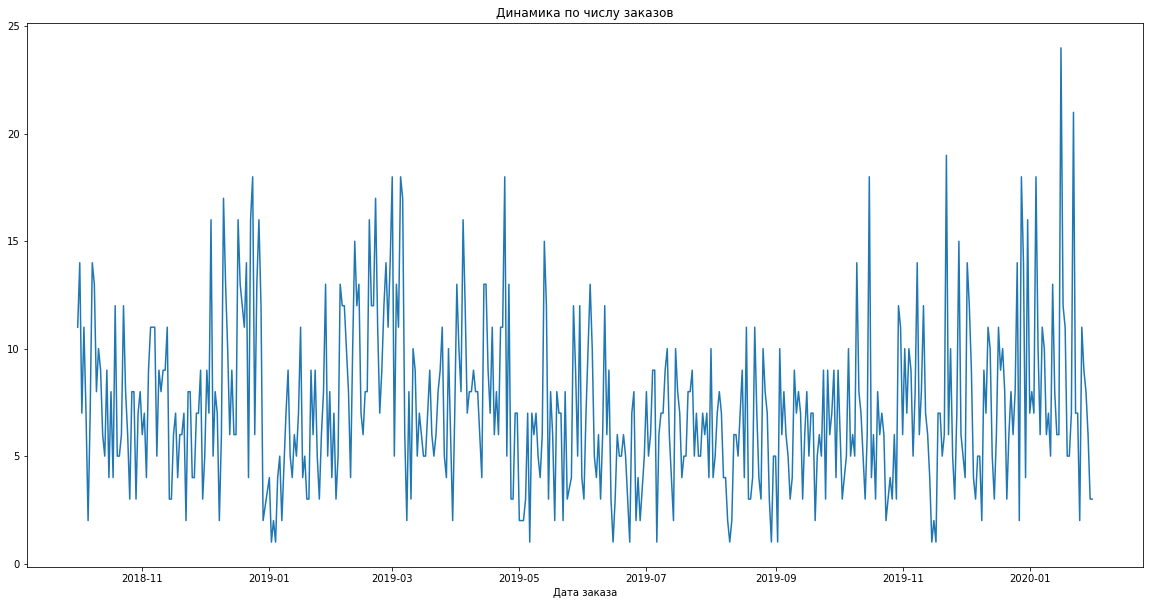

In [132]:
df_addon.groupby('order_date').agg({'order_id':'nunique'}).plot(figsize=(20, 10), legend=False)
plt.title('Динамика по числу заказов')
plt.xlabel('Дата заказа')
plt.show()

Судя по графику как таковой "высокий сезон" у магазина отсутствует, но есть небольшая просадка по числу заказов в период с июля по октябрь.

# Динамика по числу заказов по месяцам за все время, представленное в датафрейме

Text(0.5, 0, 'Месяц')

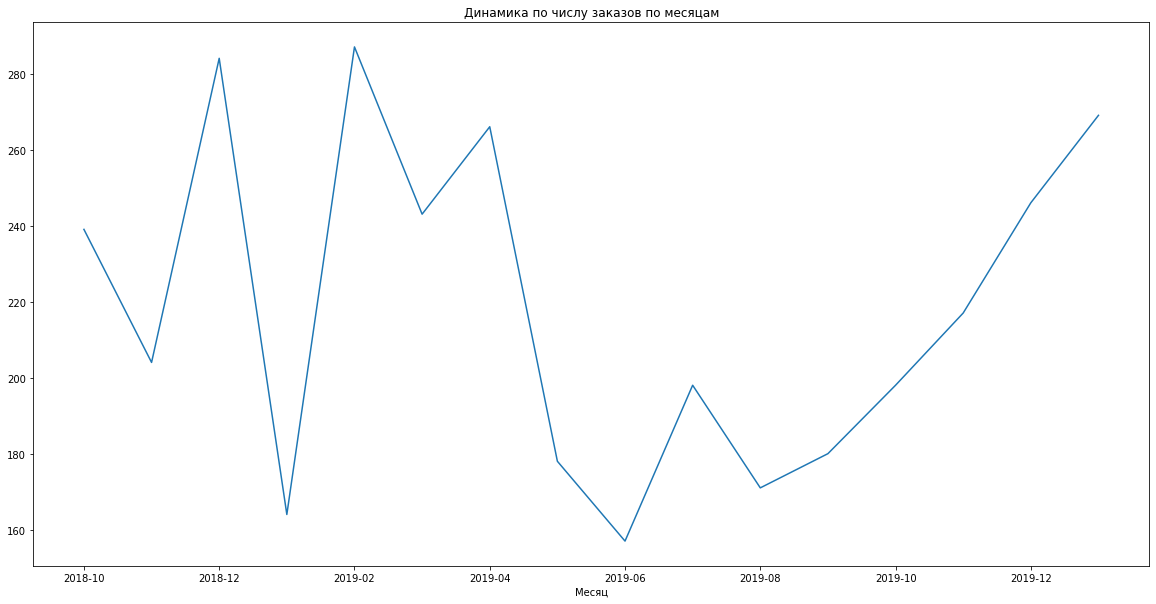

In [133]:
df_addon.groupby('month').agg({'order_id':'nunique'}).plot(figsize=(20, 10), legend=False)
plt.title('Динамика по числу заказов по месяцам')
plt.xlabel('Месяц')

Судя по этому графику наиболее удачные месяцы у магазина с точки зрения числа заказов - это декабрь 2018 года, февраль-апрель 2019 года, а также ноябрь-январь 2019-2020 годов.

# Динамика по выручке по месяцам за все время, представленное в датафрейме

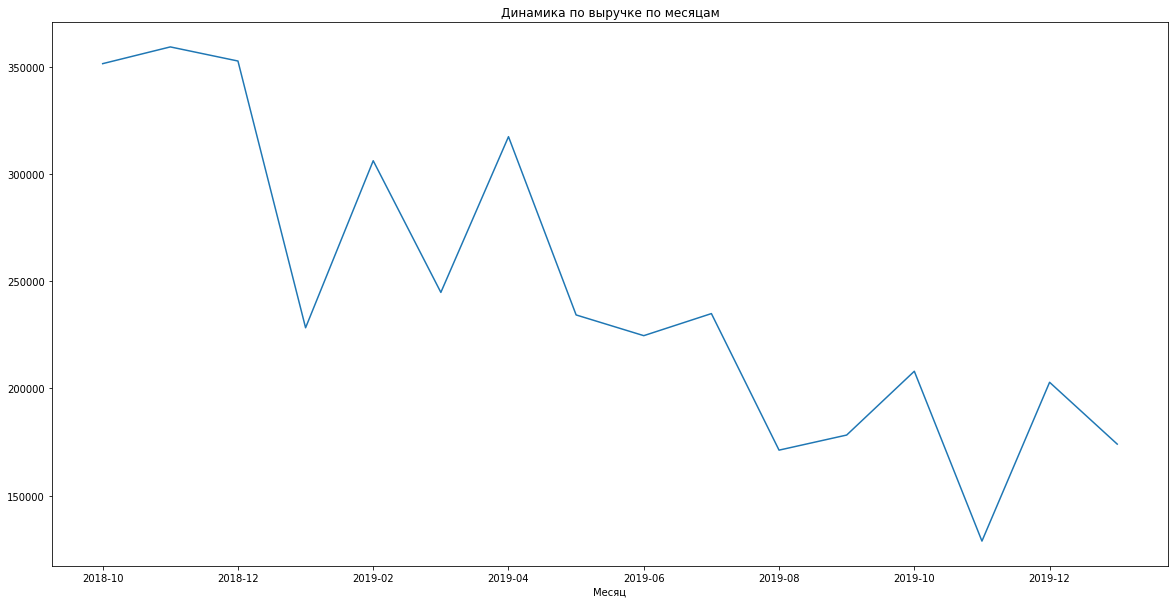

In [134]:
df_addon.groupby('month').agg({'revenue':'sum'}).plot(figsize=(20, 10), legend=False)
plt.title('Динамика по выручке по месяцам')
plt.xlabel('Месяц')
plt.show()

В отличие от двух первых графиков, где все выглядело неплохо (в сезон наступал рост числа заказов), график выручки магазина показывает, что она снижается в течение всего периода, рассматриваемого в датафрейме.

# Динамика по числу покупателей по месяцам за все время, представленное в датафрейме

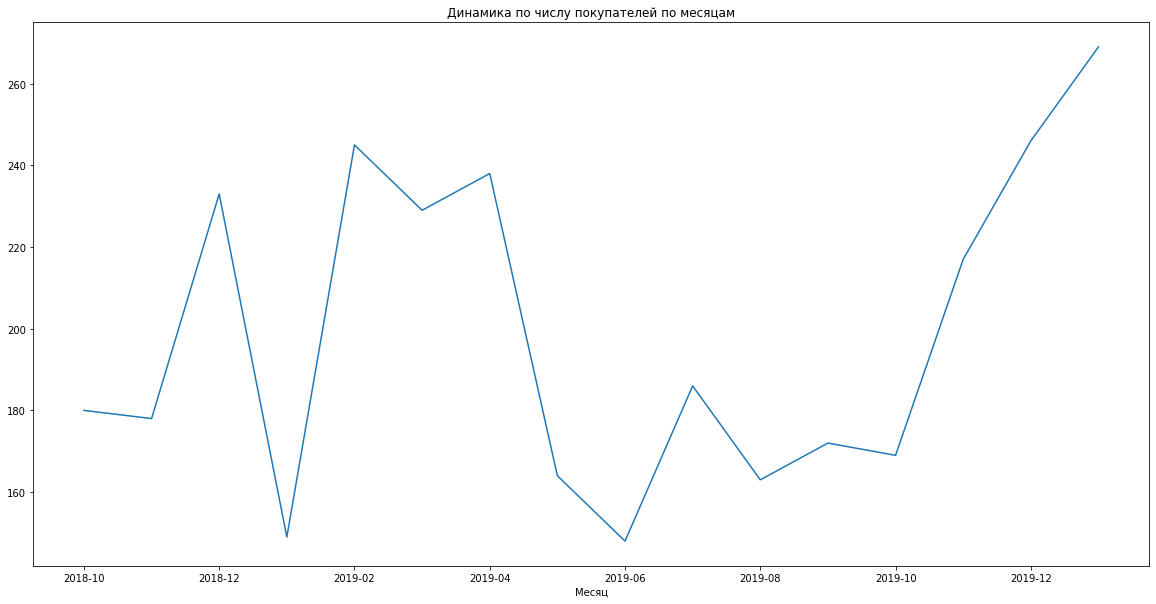

In [135]:
df_addon.groupby('month').agg({'customer_id':'nunique'}).plot(figsize=(20, 10), legend=False)
plt.title('Динамика по числу покупателей по месяцам')
plt.xlabel('Месяц')
plt.show()

Этот график в достаточно сильной степени повторяет график по динамике числа заказов в месяц.

# Выводы по Исследовательскому анализу данных:

1. Мы изучили число уникальных покупателей, заказов и продуктов в датафрейме, здесь ничего необычного найдено не было.

2. Далее были изучены распределения по кол-ву покупаемых товаров и ценам купленных товаров. Аномальные значения не удаляли, убрали только 1 тестовый заказ на 1000 вантузов.

3. При анализе уникальности заказов было найдено более 1800 дублей, которые мы удалили. Также были удалены заказы, где разные пользователи попадали в одни и те же заказы.

4. В датафрейм были добавлены данные по стоимости заказа, а также более полные данные по датам заказов (выделены в отдельные столбцы месяцы, недели, дни, часы и даты заказа без времени), они понадобятся нам для дальнейшего анализа.

5. Провели первичный анализ ассортимента магазина, изучив ТОП-60 наиболее часто попадающихся в заказах наименований товаров. Оказалось, что речь идет про хозяйственный магазин, в котором серьезную долю ассортимента занимают саженцы и домашние растения.

6. Изучили основные бизнес-метрики магазина:
* динамику по числу заказов за все время, представленное в датафрейме (показала, что как такового сезона у магазина нет, есть лишь небольшая просадка по числу заказов с июля по октябрь);
* динамику по числу заказов и покупателей по месяцам за все время, представленное в датафрейме (показала наиболее удачные месяцы:декабрь 2018 года, февраль-апрель 2019 года, а также ноябрь-январь 2019-2020 годов);
* динамику по выручке по месяцам за все время, представленное в датафрейме (показала неуклонное падение на протяжении всего времени датафрейма).

Получается, что у магазина явные проблемы с выручкой, раз она неуклонно снижается.

# Шаг 3. Статистический анализ данных

# Исследование товарной матрицы

Проведем более детальное исследование товарной матрицы магазина на основании данных по заказам из датафрейма. Выведем число уникальных товаров еще раз:

In [136]:
df_addon['product'].nunique()

2335

Выведем полный список уникальных товаров:

In [137]:
df_addon
pd.set_option('display.max_row', 2305)
pd.set_option('max_colwidth', 200)
products = df_addon.groupby('product')['order_id'].count()
products = products.reset_index()
products = products.drop(columns='order_id')
products.sort_values(by='product')

,product
0,Tepмокружка AVEX Freeflow 700 мл зеленый AVEX0759
1,Tepмокружка AVEX Freeflow 700 мл сталь AVEX0776
2,Tepмокружка AVEX Recharge 500 мл голубой AVEX0681
3,Ёрш бутылочный с металлической ручкой малый Y64 1807002
4,"Ёрш для бутылки из натурального волокна и металла 23 см кремовый, Burstenmann, 0473/0003"
...,...
2330,томата (помидор) Ширли сердцевидный № 119 сорт индетерминантный среднеспелый розовый
2331,томата (помидор) Этуаль №85 сорт детерминантный среднеспелый розовый
2332,томата (помидор) Южный вечер № 120 сорт детерминантный среднеспелый черный
2333,томата (помидор) Юсуповский Узбекский №86 сорт индетерминантный позднеспелый красный


Лемматизируем этот список для дальнейшей категоризации:

In [138]:
lemmas = []

for i in df_addon['product'].unique():
    lemmas = ' '.join(m.lemmatize(i))
    lemmas = lemmas.split()
    print(lemmas)

['комнатный', 'растение', 'в', 'горшок', 'алый', 'вера', ',', 'd12', ',', 'h30']
['комнатный', 'растение', 'в', 'горшок', 'кофе', 'арабика', ',', 'd12', ',', 'h25']
['радермахер', 'd', '-', '12', 'см', 'h', '-', '20', 'см']
['хризолидокарпус', 'лутесценс', 'd', '-', '9', 'см']
['циперус', 'зумула', 'd', '-', '12', 'см', 'h', '-', '25', 'см']
['шеффлер', 'лузеан', 'd', '-', '9', 'см']
['юкка', 'нитчатый', 'd', '-', '12', 'см', 'h', '-', '25', '-', '35', 'см']
['настенный', 'сушилка', 'для', 'белье', 'Gimi', 'Brio', 'Super', '100']
['таз', 'пластмассовый', '21', ',', '0', 'л', 'круглый', '"', 'водолей', '"', 'С614', ',', '1404056']
['чехол', 'для', 'гладильный', 'доска', 'Colombo', 'Persia', 'Beige', '130х50', 'см', 'из', 'хлопок', '5379']
['вешалка', 'для', 'брюки', 'металлический', 'с', 'резиновый', 'покрытие', '26', 'см', 'цвет', ':', 'синий', ',', 'Attribute', ',', 'AHS331']
['сушилка', 'для', 'белье', 'потолочный', 'Zalger', 'Lift', 'Basic', '1520', '200', 'см', ',', '10', 'м']
['че

Сопоставим названия товаров с названиями будущих товарных категорий:

In [139]:
flowers = ['цветок', 'цветы', 'горшок', 'букет', 'цветущий', 'домашний', 'комнатный', 'однолетний', 'радермахер', 'хризолидокарпус',  'циперус', 'шеффлер', 'юкка',  'пеларгония', 'суккулент', 'эхеверие', 'эвкалипт', 'кампануть',  'нолина',  'хлорофитум', 'цикламен', 'глоксиния',  'азалия', 'гортензия',  'хризантема', 'мирт',  'кориандр', 'иссоп', 'сантолина', 'аспарагус',  'антуриум', 'молодило', 'фиалка', 'гербера', 'душица', 'мелисса', 'роза',  'бегония',  'альбук',  'бальзамин',  'крассула',  'артемизия',  'лаванда',  'мята',  'каланхое', 'примула', 'дендробиум',  'калоцефалус',  'каллун', 'капсикум',  'мимоза',  'соланум',  'бархатцы', 'косметь',  'настурция',  'петуния',  'алиссум', 'гвоздик', 'годеция', 'календула',  'кореопсис',  'лапчатка',  'флокс',  'цинерария', 'эшшольция', 'диффенбахий',  'фаленопсис',  'пуансетия',  'аптение', 'пуансеттия',  'скиммия', 'фиттоний',  'алоэ',  'спатифиллум', 'фикус', 'гимнокалициум', 'калатея', 'эхинокактус', 'гипсофил', 'калибрахоа', 'эпипремнум', 'аквилегия',  'незабудка', 'седум', 'нефролепис', 'калла', 'тюльпан',  'штангенциркуль',  'чабер', 'бакоп',  'ранункулус',  'овсянница', 'георгин', 'смолевка', 'цинния', 'вербейник', 'колокольчик', 'котовник', 'эхинацея',  'ясколка',  'афеляндра',  'виола',  'лилейник', 'папоротник', 'платикодон',  'энотера', 'вербена', 'фуксия',  'цитрофортунелла',  'пеперомия',  'гардения',  'лобелия',  'фиксатор',  'пиретрум', 'муррайя', 'вероника', 'джункус',  'драцена', 'фатсия', 'японский', 'хоста', 'гайлардий',  'монард', 'нивянник', 'рудбекия', 'барвинок', 'осина', 'пряный', 'астра', 'бузульник', 'камнеломка', 'солидаго', 'физостегия', 'бадан', 'лен', 'лавр', 'лантан', 'лаватер', 'анемон', 'валериана', 'змееголовник', 'любисток',  'табак', 'шалфей', 'вигна', 'хамедорей', 'зверобой', 'мединилла', 'импатиенс', 'замиокулькас', 'завертка', 'пахира', 'литопс', 'адиантум', 'гербера', 'аптения', 'монарда']
everything_for_home =  ['ёрш', 'щетка',  'пакет', 'ванна', 'вантуз', 'ведро', 'веник', 'вешалка',  'хранение',  'доска',  'белье', 'коробка', 'бумага',  'ерш', 'сумка', 'тележка', 'штора', 'корыто', 'коврик', 'стремянка', 'ника',  'салфетка', 'таз', 'стяжка',  'полка',   'чехол', 'ковш', 'швабра', 'перчатки',  'ковёр', 'кофр', 'ваза', 'корзина', 'лоток', 'окно', 'ванна', 'алюминий', 'комод',  'набор', 'сушилка', 'плед', 'урна', 'скалка', 'обувь', 'наматрасник', 'ванна', 'кашпо',  'тряпкодержатель', 'пружина', 'сварка', 'полотенце', 'шприц',  'ковер', 'крючок', 'петля',  'форма', 'фоторамка', 'ролик', 'угольник', 'перчатка', 'скребок', 'контейнер', 'обувница', 'покрывало', 'сребок', 'мешок', 'халат', 'тряпка', 'ящик', 'одеяло', 'насадка', 'ручка', 'термокружок',  'дозатор', 'простыня', 'плечики', 'подушка', 'светильник', 'короб', 'подголовник', 'лопатка', ' совок', 'унитаз', 'салфетница', 'алюминиевый', 'ножницы', 'кисточка', 'сетка', 'экран', 'термос', 'ключница', 'штанга', 'наматрацник', 'бельевой', 'сверло', 'карниз', 'корзинка', 'шнур', 'пьезозажигалка', 'уголок', 'решетка', 'оконный', 'ткань', 'комплект',  'инструмент', 'наволочка', 'пододеяльник', 'детский', 'отделитель', 'веревка', 'совок', 'линейка', 'фал', 'шпагат', 'основание', 'подставка', 'бидон']
technic = ['весы', 'электроштопор','окномойка', 'утюг', 'овощеварка', 'машина', 'плита', 'кипятильник', 'фен', 'миксер', 'соковарка', 'соковыжималка', 'мантоварка']
seeds = ['рассада' , 'семена', 'черенок', 'растение', 'дерево', 'арбуз', 'базилик', 'баклажан', 'дыня', 'кофе', 'кабачок', 'томат', 'тыква', 'лук', 'капуста', 'огурец', 'капуста', 'салат', 'клубника', 'земляника', 'укроп', 'тимьян', 'розмарин', 'петрушка', 'рукол', 'подсолнечник', 'сельдерей', 'горох', 'виноград', 'морковь', 'патиссон']
household_chemicals = ['средство', 'антижир', 'антинакипин', 'бак', 'мытье', 'бензин', 'иж', 'мыло', 'отбеливатель','маска', 'крем']
dummy = ['муляж', 'искуственный', 'искусственный']
everything_for_kitchen = ['рыбочистка', 'кружка', 'банка', 'блюдо', 'скатерть', 'свч', 'нож', 'тортница’, ‘кастрюля', 'соль', 'бокал', 'паста', 'мука', 'сахарница', 'терка', 'тарелка', 'кувшин','ложка', 'салатник', 'хлебница', 'сковорода',  'чайник', 'хлебница', 'сковорода', 'миска', 'сито', 'венчик', 'блюдо', 'котел', 'толкушка', 'сотейник', 'ножеточка', 'масленка',  'блюдце', 'бульонница', 'масленка', 'орехоколка', 'овощечистка', 'термокружка', 'tepмокружка',  'термостакан', 'половник', 'пресс', 'стакан', 'губка', 'посуда', 'вилка', 'кастрюля', 'тортница']

Поделим товары на категории:

In [140]:
def lemm_kategor(product):
    lemmas = ' '.join(m.lemmatize(product))
    lemmas = lemmas.split()
    for i in lemmas:
        if i in technic:
            return 'Бытовая техника'
        if i in dummy:
            return 'Муляжи и искусственные растения'
        if i in seeds:
            return 'Семена и рассада'
        if i in flowers:
            return 'Цветы'
        if i in everything_for_home:
            return 'Все для дома'
        if i in household_chemicals:
            return 'Бытовая химия' 
        if i in everything_for_kitchen:
            return 'Все для кухни'
    return 'Другое'

Добавим столбец с товарной категорией в датафрейм и проверим результат:

In [141]:
df_addon['product_kategor'] = df_addon['product'].apply(lemm_kategor)
df_addon

,date,customer_id,order_id,product,quantity,price,revenue,month,week,day,hour,order_date,product_kategor
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,2018-10,2018-39,0,0,2018-10-01,Цветы
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,194.0,2018-10,2018-39,0,0,2018-10-01,Цветы
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,2018-10,2018-39,0,0,2018-10-01,Цветы
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,2018-10,2018-39,0,0,2018-10-01,Цветы
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,2018-10,2018-39,0,0,2018-10-01,Цветы
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5523,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт индетерминантный позднеспелый черный,2,38.0,76.0,2020-01,2020-04,3,21,2020-01-30,Семена и рассада
5524,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,Дендробиум Санок Анна Грин 1 ствол d-12 см,1,869.0,869.0,2020-01,2020-04,3,22,2020-01-30,Цветы
5525,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 см AMC080,1,354.0,354.0,2020-01,2020-04,4,2,2020-01-31,Все для дома
5526,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цветов в кассете по 6 шт,1,128.0,128.0,2020-01,2020-04,4,12,2020-01-31,Семена и рассада


Проверим, остались ли нераспределенные по категориям товары:

In [142]:
len(df_addon.query('product_kategor == "Другое"'))

18

Нераспределенных товаров осталось всего 18 штук. Посмотрим, что это за товары:

In [143]:
df_addon.query('product_kategor == "Другое"')

,date,customer_id,order_id,product,quantity,price,revenue,month,week,day,hour,order_date,product_kategor
201,2018-10-11 18:00:00,cfddc890-ecaf-4f04-ab0f-ffa76c79fe63,68615,Азалия индика Биколор d-12 см,1,307.0,307.0,2018-10,2018-40,3,18,2018-10-11,Другое
339,2018-10-22 22:00:00,662f1eae-7111-44f3-aa45-797eee140546,68721,Гербера d-13 см,1,194.0,194.0,2018-10,2018-42,0,22,2018-10-22,Другое
952,2018-12-03 11:00:00,2c8b9386-2e8c-4ee9-8aa4-2b4875b68578,14514,"Эшшольция Карминный король 0,5 г 4660010770193",2,10.0,20.0,2018-12,2018-48,0,11,2018-12-03,Другое
1038,2018-12-12 14:00:00,0946f283-946c-4fc9-b7b0-9c9f73f87acd,69326,Аптения d-10 см h-10 см,1,134.0,134.0,2018-12,2018-49,2,14,2018-12-12,Другое
1053,2018-12-14 13:00:00,f50502a7-86ff-41a6-84b5-0c4b0f174220,69361,Аптения d-10 см h-10 см,1,134.0,134.0,2018-12,2018-49,4,13,2018-12-14,Другое
1333,2019-01-21 22:00:00,803199fd-9cc6-4310-aa7c-83629fa867c6,69912,Аптения d-12 см h-15 см,2,187.0,374.0,2019-01,2019-03,0,22,2019-01-21,Другое
1406,2019-02-01 12:00:00,223c92c6-a951-4307-a8c3-19bdc455eb79,70055,Азалия Индика фиолетовая d-10 см h-20,1,209.0,209.0,2019-02,2019-04,4,12,2019-02-01,Другое
1924,2019-03-09 21:00:00,adb341bf-ce59-44ad-8d69-5a1aa1f047be,70674,Азалия Индика розовая d-12 см h-20,1,344.0,344.0,2019-03,2019-09,5,21,2019-03-09,Другое
2218,2019-04-03 21:00:00,65ed0726-5565-4c0e-905c-f9e9bd9f7642,70999,Афеляндра скуарроса Дания d-12 см,1,547.0,547.0,2019-04,2019-13,2,21,2019-04-03,Другое
2284,2019-04-06 17:00:00,3671811d-b3c0-45f4-a310-269ffeed3395,71041,Аптения d-10 см h-10 см,1,134.0,134.0,2019-04,2019-13,5,17,2019-04-06,Другое


Их названия включены в товарные категории. В любом случае, такое небольшое число товаров в категории "Другое" не исказит выводы исследования. Далее оценим распределение долей товарных категорий:

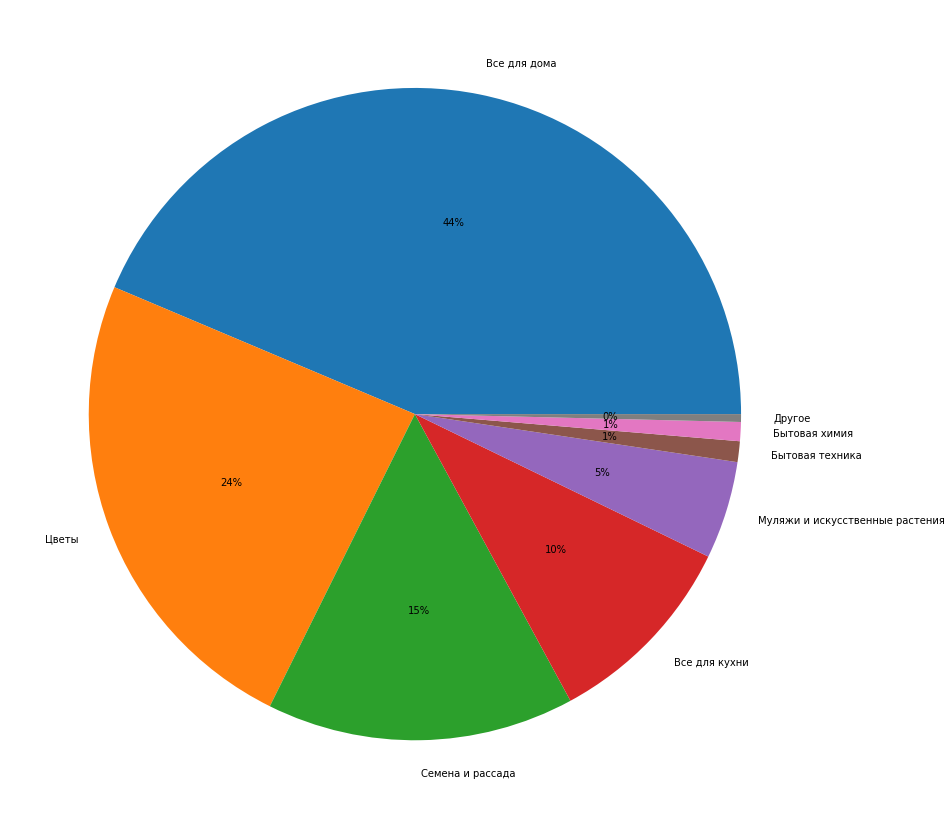

In [144]:
plt.figure(figsize=(15, 15))
graf=df_addon.groupby('product_kategor')['product'].nunique().sort_values(ascending=False)
labels=graf.index
plt.pie(graf, labels=labels, autopct='%.0f%%')
plt.show()

Товары разделены на 7 категорий, также есть категория "Другие", но в ней товаров, доля которых близка в 0%. Лидерами продаж являются такие категории:
* Все для дома - 44%;
* Цветы - 24%;
* Семена и рассада - 15%;
* Все для кухни - 10%;
* Муляжи и искусственные растения - 5%.

Бытовая техника и Бытовая химия занимают по 1% от суммарной доли продаж магазина.

# Исследование товаров-лидеров продаж

Выведем список товаров, которые продаются чаще всего:

In [145]:
top_products = df_addon.groupby('product')['order_id'].count().sort_values(ascending=False).head(60)
top_products = top_products.reset_index()
top_products

,product,order_id
0,Пеларгония розебудная Red Pandora укорененный черенок,65
1,Пеларгония розебудная Prins Nikolai укорененный черенок,56
2,Пеларгония зональная диам. 12 см сиреневый полумахровый,53
3,Сумка-тележка 2-х колесная Gimi Argo синяя,47
4,Пеларгония розебудная Mary укорененный черенок,39
5,Пеларгония розебудная Margaretha укорененный черенок,31
6,Пеларгония розебудная Queen Ingrid укорененный черенок,31
7,Пеларгония зональная махровая лососевая,25
8,Пеларгония зональная Ринго Вайт d-7 см h-10 см укорененный черенок,25
9,Пеларгония зональная диам. 12 см коралловая полумахровая,24


В ТОП-20 продаваемых товаров чаще всего (14 раз) встречаются различные варианты растения Пеларгония. Также много других растений. Посмотрим, к каким категориям относятся продаваемые товары:

In [146]:
top_products_kat = df_addon.groupby('product_kategor')['order_id'].count().sort_values(ascending=False)
top_products_kat

product_kategor
Все для дома                       2045
Цветы                              1884
Семена и рассада                    877
Все для кухни                       353
Муляжи и искусственные растения     273
Бытовая техника                      43
Бытовая химия                        35
Другое                               18
Name: order_id, dtype: int64

Визуализируем результат для большей наглядности:

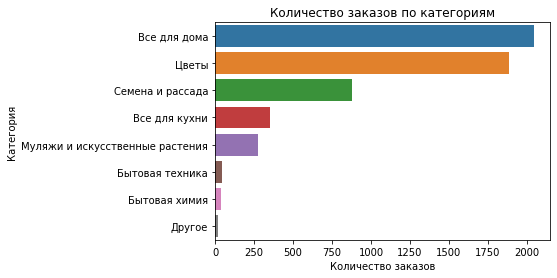

In [147]:
top_products_kat_1=top_products_kat.reset_index()

sns.barplot(x='order_id', y='product_kategor', data=top_products_kat_1)
plt.title('Количество заказов по категориям')
plt.xlabel('Количество заказов')
plt.ylabel('Категория')
plt.show()

ТОП-2 примерно с одинаковым результатом делят категории "Все для дома" (2045 товаров) и "Цветы" (1884 товара). Далее с большим оставанием идут "Семена и рассада" (877 товаров). 

Оценим соотношение долей каждой категории в процентах:

In [148]:
grouped_category = df_addon.groupby('product_kategor').agg({'product':'count', 'revenue':'sum'})\
.reset_index().rename(columns={'product':'cnt_products'})
grouped_category['percent_of_products'] = (grouped_category['cnt_products'] / len(df_addon))
grouped_category = grouped_category.sort_values(by='percent_of_products', ascending = False)
grouped_category['percent_of_products'] = grouped_category['percent_of_products'].map('{:.2%}'.format)

Посмотрим, какие товары приносят наибольшую прибыль:

In [149]:
top_income = df_addon[['product', 'price', 'quantity']]
top_income['total'] = top_income['price'] * top_income['quantity']
top_income = top_income.groupby('product')['total'].sum().sort_values(ascending=False).head(30)
top_income = top_income.reset_index()
top_income

,product,total
0,Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок,53232.0
1,Сумка-тележка 2-х колесная Gimi Argo синяя,50405.0
2,Вешалки мягкие для деликатных вещей 3 шт шоколад,49596.0
3,Тележка багажная DELTA ТБР-22 синий грузоподъемность 20 кг сумка и 50 кг каркас РОССИЯ,33992.0
4,Муляж ЯБЛОКО 9 см красное,32702.0
5,Набор ножей Attribute CHEF 5 предметов AKF522,29248.0
6,"Сумка-тележка хозяйственная Andersen Scala Shopper Plus, Lini, синяя 133-108-90",28045.0
7,Сушилка Meliconi Stendy Junior,27970.0
8,Мусорный контейнер Hailo BigBin Swing 45 0845-010 45 л хром,27560.0
9,"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см, сталь",24370.0


Больше всего дохода приносят такие позиции:
* "Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок" (53232 у.е.);
* "Сумка-тележка 2-х колесная Gimi Argo синяя" (50405);
* Вешалки мягкие для деликатных вещей 3 шт шоколад (49596 у.е.).

Далее оценим лидеров по доходам среди категорий:

In [150]:
top_income_kat = df_addon[['product_kategor','order_id', 'price', 'quantity', 'date']]
top_income_kat['total'] = top_income_kat['price'] * top_income_kat['quantity']
top_income_kat_1 = top_income_kat.groupby('product_kategor')['total'].sum().sort_values(ascending=False)
top_income_kat_1

product_kategor
Все для дома                       2.957199e+06
Цветы                              4.187433e+05
Все для кухни                      2.545640e+05
Семена и рассада                   1.199640e+05
Муляжи и искусственные растения    1.068633e+05
Бытовая техника                    4.040000e+04
Бытовая химия                      1.418200e+04
Другое                             5.676000e+03
Name: total, dtype: float64

Визуализируем результат для большей наглядности:

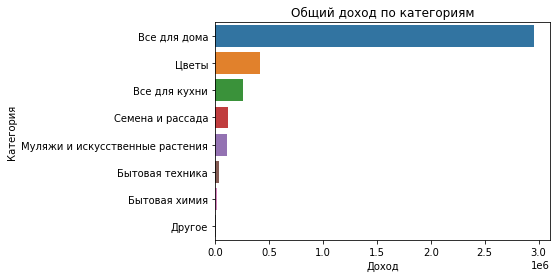

In [151]:
top_income_kat_2 = top_income_kat_1.reset_index()

sns.barplot(x='total', y='product_kategor', data=top_income_kat_2) 
plt.title('Общий доход по категориям')
plt.xlabel('Доход')
plt.ylabel('Категория')
plt.show()

Категория "Все для дома" лидирует с огромным отрывом.

Оценим общий доход магазина за время, представленное в датафрейме:

In [152]:
top_income_kat['total'].sum()

3917591.4166666665

Оценим, какой доход принесли самые продаваемые товары:

In [153]:
top_income['total'].sum()

705723.5

Оценим их долю от общего дохода магазина:

In [154]:
print(round((top_income['total'].sum()/top_income_kat['total'].sum())*100, 1), '%')

18.0 %


Оценим долю дохода, которую приносит лидер среди категорий - "Все для дома":

In [155]:
print(round((top_income_kat_1[0]/top_income_kat['total'].sum())*100, 1), '%')

75.5 %


Теперь понятно, что в основном доход магазину приносит продажа товаров из категории "Все для дома" - 75,5%. При этом на лидеров продаж среди товаров приходится 18% дохода магазинов. Посмотрим какие товары приносят большой доход при частых продажах:

In [156]:
for i in top_income['product']:
    for j in top_products['product']:
        if i == j:
            print(i)

Сумка-тележка 2-х колесная Gimi Argo синяя
Сумка-тележка 2-х колесная складная Gimi Flexi зеленая


Найдено 2 таких товара. Посмотрим, к каким категориям они принадлежат:

In [157]:
print(df_addon[df_addon['product'] == 'Сумка-тележка 2-х колесная Gimi Argo синяя']['product_kategor'].unique()) 
print(df_addon[df_addon['product'] == 'Сумка-тележка 2-х колесная складная Gimi Flexi зеленая']['product_kategor'].unique())

['Все для дома']
['Все для дома']


Оба товара относятся к категории "Все для дома". На продажу этих товаров нужно делать ставку. Посмотрим, с чем они хорошо продаются:

In [158]:
top_orders = df_addon[df_addon['product']== 'Сумка-тележка 2-х колесная Gimi Argo синяя']['order_id'].unique()
for i in top_orders:
    print(df_addon[df_addon['order_id'] == i])

                  date                           customer_id  order_id  \
21 2018-10-02 10:00:00  4d93d3f6-8b24-403b-a74b-f5173e40d7db     68491   

                                       product  quantity   price  revenue  \
21  Сумка-тележка 2-х колесная Gimi Argo синяя         1  1049.0   1049.0   

      month     week  day  hour  order_date product_kategor  
21  2018-10  2018-39    1    10  2018-10-02    Все для дома  
                   date                           customer_id  order_id  \
122 2018-10-07 20:00:00  ae8e32f4-ff7f-4ee4-bef9-f223caa9a3dd     68559   

                                        product  quantity   price  revenue  \
122  Сумка-тележка 2-х колесная Gimi Argo синяя         1  1049.0   1049.0   

       month     week  day  hour  order_date product_kategor  
122  2018-10  2018-40    6    20  2018-10-07    Все для дома  
                   date                           customer_id  order_id  \
149 2018-10-09 11:00:00  0b0ea807-ff4e-4bbf-b6be-5b7343b8af9d  

In [159]:
top_orders = df_addon[df_addon['product']== 'Сумка-тележка 2-х колесная складная Gimi Flexi зеленая']['order_id'].unique()
for i in top_orders:
    print(df_addon[df_addon['order_id'] == i])

                   date                           customer_id  order_id  \
290 2018-10-19 10:00:00  c971fb21-d54c-4134-938f-16b62ee86d3b     68686   

                                                    product  quantity   price  \
290  Сумка-тележка 2-х колесная складная Gimi Flexi зеленая         1  1649.0   

     revenue    month     week  day  hour  order_date product_kategor  
290   1649.0  2018-10  2018-41    4    10  2018-10-19    Все для дома  
                    date                           customer_id  order_id  \
1062 2018-12-15 16:00:00  19bf691d-c946-4de7-a2f3-5e646ee8bba3     69377   

                                                     product  quantity  \
1062  Сумка-тележка 2-х колесная складная Gimi Flexi зеленая         2   

       price  revenue    month     week  day  hour  order_date product_kategor  
1062  1649.0   3298.0  2018-12  2018-49    5    16  2018-12-15    Все для дома  
                    date                           customer_id  order_id  \
10

Оба этих товара чаще всего продаются без сопутствующих товаров.

# Исследование категорий-лидеров продаж

Посмотрим, товары каких категорий при продажах идут в заказе с товарами других категорий:

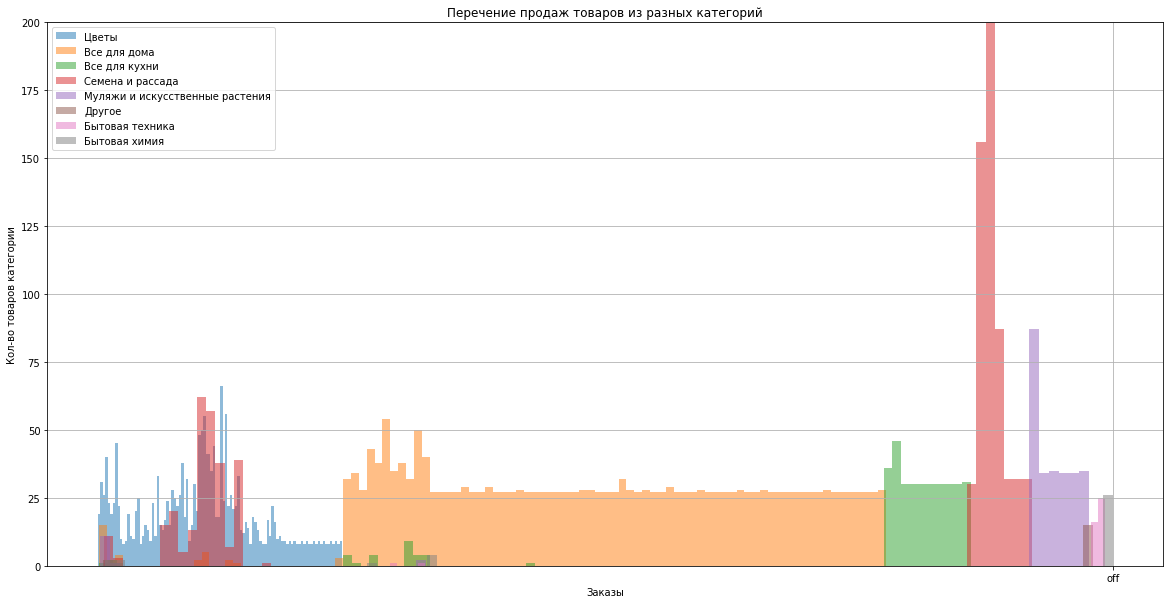

In [160]:
products = df_addon
products['order_id'] = products['order_id'].astype('str')

plt.figure(figsize=(20, 10))

for i in products['product_kategor'].unique():
    graf1=products.query('product_kategor==@i')
    graf1['order_id'].hist(bins=100, alpha=0.5, label=i)

plt.title('Перечение продаж товаров из разных категорий')
plt.xlabel('Заказы')  
plt.ylabel('Кол-во товаров категории')
plt.ylim([0, 200])
plt.legend()
plt.xticks('off')
plt.show()

Видно, что категории "Все для дома", "Все для кухни" и "Муляжи и искусственные растения" чаще всего продаются без сопутствующих товаров из других категорий.
А вот товары категорий "Семена и рассада" и "Цветы" часто являются в заказах сопутствующими.

Оценим продажу товаров разных категорий с точки зрения сезонности:

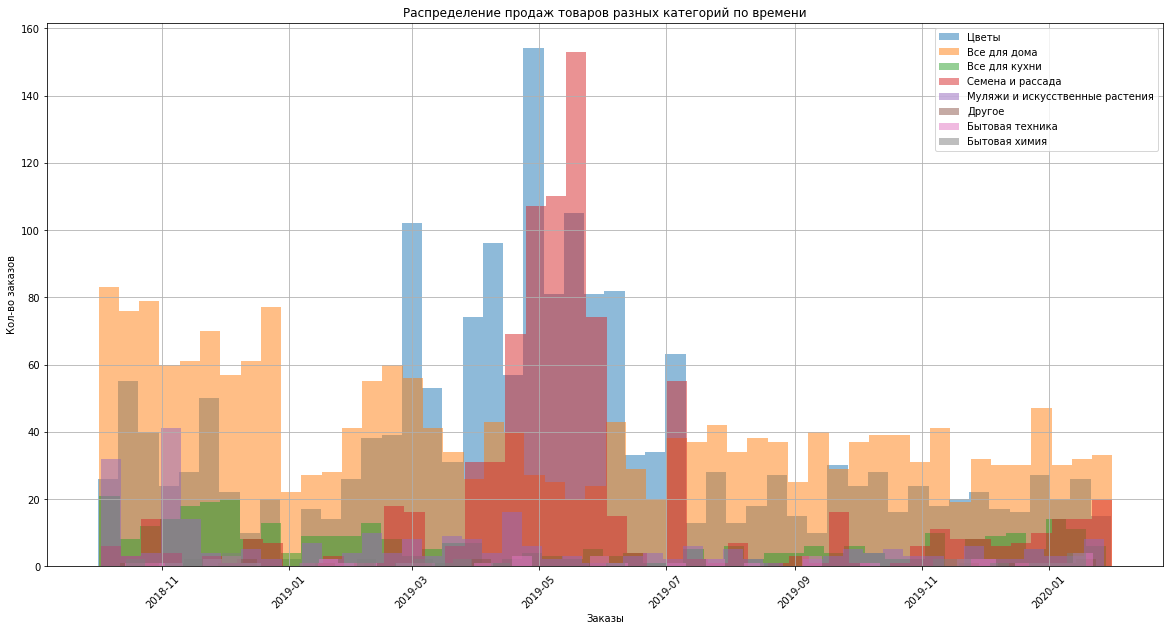

In [161]:
plt.figure(figsize=(20, 10))

for i in df_addon['product_kategor'].unique():
    graf2=df_addon.query('product_kategor==@i')
    graf2['date'].hist(bins=50, alpha=0.5, label=i)

plt.title('Распределение продаж товаров разных категорий по времени')
plt.xlabel('Заказы')  
plt.ylabel('Кол-во заказов')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Ярко выраженная сезонность наблюдается только у товаров из категорий "Семена и рассада" (с мая по июнь) и "Цветы" (с марта по июнь). Остальные товары продаются круглый год.

Для полноты картины оценим корреляцию продаж товаров разных категорий:

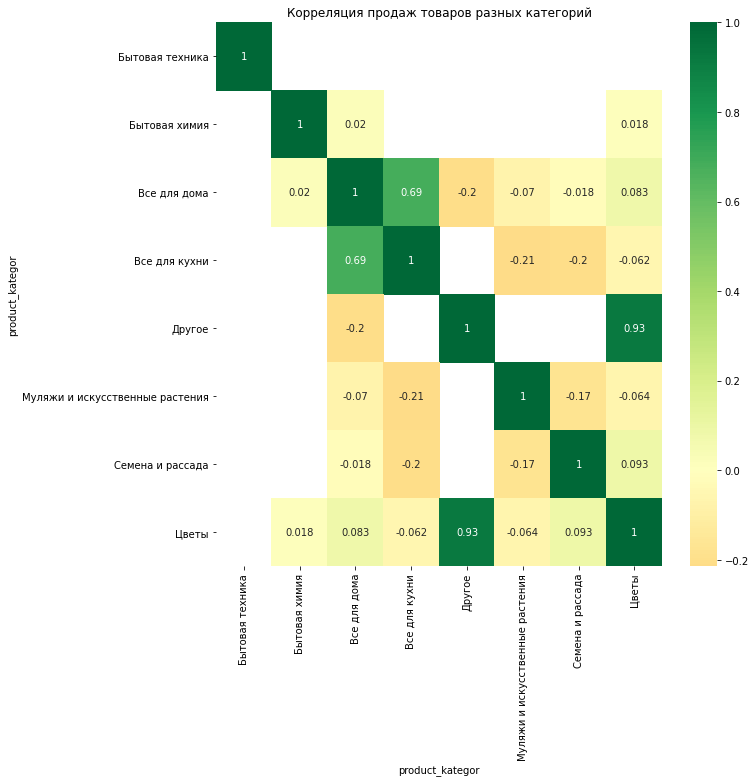

In [162]:
kat_corr=pd.pivot_table(df_addon, index='date', columns='product_kategor', values='quantity', aggfunc='sum')

plt.figure(figsize=(10,10))
sns.heatmap(kat_corr.corr(), xticklabels=kat_corr.corr().columns, yticklabels=kat_corr.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Корреляция продаж товаров разных категорий')

plt.show()

Товары категорий "Все для дома" и "Все для кухни" имеют достаточно сильную корреляцию продаж. У товаров других категорий такой зависимости нет. С учетом небольших продаж товаров категорий "Бытовая техника" и "Бытовая химия", можно рассмотреть вопрос об исключении этих типов товаров из ассортимента магазина. Их удаление не скажется отрицательно на продажах других товарных категорий.

# Выводы по Статистическому анализу данных:

1. Мы провели исследование и кластеризацию товарной матрицы, разделив товары на 7 категорий: "Бытовая техника", "Муляжи и искусственные растения", "Семена и рассада", "Цветы", "Все для дома", "Бытовая химия" и "Все для кухни".


2. Лидерами продаж оказались такие категории:
* Все для дома - 44%;
* Цветы - 24%;
* Семена и рассада - 15%;
* Все для кухни - 10%;
* Муляжи и искусственные растения - 5%.
* Бытовая техника и Бытовая химия занимают по 1% от суммарной доли продаж магазина.


3. Исследование товаров-лидеров продаж показало, что в ТОП-20 продаваемых товаров чаще всего (14 раз) встречаются различные варианты растения Пеларгония, также в ТОПе много других растений.


4. При это если говорить про ТОП-категорий, то 2 первых места с близким результатом делят категории "Все для дома" (2045 товаров) и "Цветы" (1884 товаров). Далее с большим отрывом идут "Семена и рассада" (877 товаров).


5. Товары-лидеры по доходам такие:
* "Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок" (53232 у.е.);
* "Сумка-тележка 2-х колесная Gimi Argo синяя" (50405 у.е.);
* "Вешалки мягкие для деликатных вещей 3 шт шоколад" (49596.0 у.е.)


6. Если говорить про лидера среди категорий по доходам, то таковым с огромным отрывом является категория "Все для дома".


7. Самые продаваемые товары принесли 18% дохода, а категория "Все для дома" - 75,5% дохода.


8. Чаще всего среди высокодоходных товаров продаются такие:
* "Сумка-тележка 2-х колесная Gimi Argo синяя"
* "Сумка-тележка 2-х колесная складная Gimi Flexi зеленая"

Оба товара относятся к категории "Все для дома". Причем, оба эти товара чаще всего продаются без сопутствующих товаров.


9. Если говорить о категорях в целом, "Все для дома", "Все для кухни" и "Муляжи и искусственные растения" чаще всего продаются без сопутствующих товаров из других категорий. А вот товары категорий "Семена и рассада" и "Цветы" часто являются в заказах сопутствующими.


10. Ярко выраженная сезонность наблюдается только у товаров из категорий "Семена и рассада" (с мая по июнь) и "Цветы" (с марта по июнь). Остальные товары продаются круглый год.


11. Товары категорий "Все для дома" и "Все для кухни" имеют достаточно сильную корреляцию продаж. У товаров других категорий такой зависимости нет. С учетом небольших продаж товаров категорий "Бытовая техника" и "Бытовая химия", можно рассмотреть вопрос об исключении этих типов товаров из ассортимента магазина. Их удаление не скажется отрицательно на продажах других товарных категорий.

# Шаг 4. Сегментация товаров и покупателей

Изучим 5 товарных категорий, на которые приходится подавляющее большинство (98%) продаж:
* Все для дома
* Цветы
* Семена и рассада
* Все для кухни
* Муляжи и искусственные растения

Разделим товары внутри каждой категории на 4 группы в зависимости от выручки, которую они приносят магазину:

# Категория "Все для дома"

In [163]:
all_for_home_goods = df_addon.query('product_kategor == "Все для дома"').reset_index(drop=True)

In [164]:
print('Верхняя граница для 1-го интервала: {:.0f}'.format(np.quantile(all_for_home_goods['revenue'], 0.25)))
print('Верхняя граница для 2-го интервала: {:.0f}'.format(np.quantile(all_for_home_goods['revenue'], 0.5)))
print('Верхняя граница для 3-го интервала: {:.0f}'.format(np.quantile(all_for_home_goods['revenue'], 0.75)))

Верхняя граница для 1-го интервала: 427
Верхняя граница для 2-го интервала: 824
Верхняя граница для 3-го интервала: 1649


Получились 4 категории товаров по доходности из рубрики "Все для дома", исходя из рассчитанных значений квантилей:

* менее 427 у.е. - "Низкая доходность";
* от 427 до 824 у.е. - "Доходность ниже средней";
* от 824 до 1649 у.е. - "Доходность выше средней";
* более 1649 у.е. - "Высокая доходность".

Составим функцию для категории "Все для дома":

In [165]:
def revenue_group(df_addon, revenue):
    
    if revenue <= np.quantile(df_addon['revenue'], 0.25):
        return 'Низкая доходность'
    if revenue <= np.quantile(df_addon['revenue'], 0.5):
        return 'Доходность ниже средней'
    if revenue <= np.quantile(df_addon['revenue'], 0.75):
        return 'Доходность выше средней'
    else:
        return 'Высокая доходность'

In [166]:
all_for_home_goods['revenue_group'] = np.nan
for i in range(len(all_for_home_goods)):
    all_for_home_goods['revenue_group'][i] = revenue_group(all_for_home_goods, all_for_home_goods['revenue'][i])

Оценим распределение заказов по каждой из 4 выделенных групп:

In [167]:
(all_for_home_goods
     .groupby('revenue_group')
     .agg({'order_id': 'nunique', 'customer_id': 'nunique'})
     .reset_index()
     .sort_values('order_id', ascending=False)
     .reset_index(drop=True))

,revenue_group,order_id,customer_id
0,Доходность выше средней,500,447
1,Доходность ниже средней,498,449
2,Высокая доходность,482,413
3,Низкая доходность,458,403


Примерно одинаково много заказов было по группам:
* "Высокая доходность" (482 штуки);
* "Доходность выше средней" (500 штук);
* "Доходность ниже средней" (498 штук).

Меньше всего заказов было по группе "Низкая доходность" (458 штук).

Число покупателей также было наибольшим у тех же 3 групп:
* "Высокая доходность" (413 человек);
* "Доходность выше средней" (449 человек);
* "Доходность ниже средней" (447 человек).

Меньше всего покупателей было по группе "Низкая доходность" (403 человека).

# Категория "Цветы"

In [168]:
flowers_goods = df_addon.query('product_kategor == "Цветы"').reset_index(drop=True)

In [169]:
print('Верхняя граница для 1-го интервала: {:.0f}'.format(np.quantile(flowers_goods['revenue'], 0.25)))
print('Верхняя граница для 2-го интервала: {:.0f}'.format(np.quantile(flowers_goods['revenue'], 0.5)))
print('Верхняя граница для 3-го интервала: {:.0f}'.format(np.quantile(flowers_goods['revenue'], 0.75)))

Верхняя граница для 1-го интервала: 112
Верхняя граница для 2-го интервала: 149
Верхняя граница для 3-го интервала: 188


Получились 4 категории товаров по доходности из рубрики "Цветы", исходя из рассчитанных значений квантилей:

* менее 112 у.е. - "Низкая доходность";
* от 112 до 149 у.е. - "Доходность ниже средней";
* от 149 до 188 у.е. - "Доходность выше средней";
* более 188 у.е. - "Высокая доходность".

Составим функцию для категории "Цветы":

In [170]:
flowers_goods['revenue_group'] = np.nan
for i in range(len(flowers_goods)):
    flowers_goods['revenue_group'][i] = revenue_group(flowers_goods, all_for_home_goods['revenue'][i])

Оценим распределение заказов по каждой из 4 выделенных групп:

In [171]:
(flowers_goods
     .groupby('revenue_group')
     .agg({'order_id': 'nunique', 'customer_id': 'nunique'})
     .reset_index()
     .sort_values('order_id', ascending=False)
     .reset_index(drop=True))

,revenue_group,order_id,customer_id
0,Высокая доходность,762,670
1,Низкая доходность,94,89
2,Доходность выше средней,47,46
3,Доходность ниже средней,43,43


Лидер с огромным отрывом по числу заказов (762 штуки) и по числу покупателей (670 человек) - группа "Высокая доходность".

Меньше всего заказов (43 штуки) и покупателей (43 человека) у группы "Доходность ниже средней".

# Категория "Семена и рассада"

In [172]:
seeds_goods = df_addon.query('product_kategor == "Семена и рассада"').reset_index(drop=True)

In [173]:
print('Верхняя граница для 1-го интервала: {:.0f}'.format(np.quantile(seeds_goods['revenue'], 0.25)))
print('Верхняя граница для 2-го интервала: {:.0f}'.format(np.quantile(seeds_goods['revenue'], 0.5)))
print('Верхняя граница для 3-го интервала: {:.0f}'.format(np.quantile(seeds_goods['revenue'], 0.75)))

Верхняя граница для 1-го интервала: 38
Верхняя граница для 2-го интервала: 119
Верхняя граница для 3-го интервала: 127


Получились 4 категории товаров по доходности из рубрики "Семена и рассада", исходя из рассчитанных значений квантилей:

* менее 38 у.е. - "Низкая доходность";
* от 38 до 119 у.е. - "Доходность ниже средней";
* от 119 до 127 у.е. - "Доходность выше средней";
* более 127 у.е. - "Высокая доходность".

Составим функцию для категории "Семена и рассада":

In [174]:
seeds_goods['revenue_group'] = np.nan
for i in range(len(seeds_goods)):
    seeds_goods['revenue_group'][i] = revenue_group(seeds_goods, all_for_home_goods['revenue'][i])

Оценим распределение заказов по каждой из 4 выделенных групп:

In [175]:
(seeds_goods
     .groupby('revenue_group')
     .agg({'order_id': 'nunique', 'customer_id': 'nunique'})
     .reset_index()
     .sort_values('order_id', ascending=False)
     .reset_index(drop=True))

,revenue_group,order_id,customer_id
0,Высокая доходность,256,236
1,Доходность ниже средней,35,34
2,Доходность выше средней,7,7
3,Низкая доходность,4,4


Лидер с огромным отрывом по числу заказов (256 штук) и по числу покупателей (236 человек) - группа "Высокая доходность".

Меньше всего заказов (4 штуки) и покупателей (4 человека) у группы "Доходность ниже средней".

# Категория "Все для кухни"

In [176]:
all_for_kitchen_goods = df_addon.query('product_kategor == "Все для кухни"').reset_index(drop=True)

In [177]:
print('Верхняя граница для 1-го интервала: {:.0f}'.format(np.quantile(all_for_kitchen_goods['revenue'], 0.25)))
print('Верхняя граница для 2-го интервала: {:.0f}'.format(np.quantile(all_for_kitchen_goods['revenue'], 0.5)))
print('Верхняя граница для 3-го интервала: {:.0f}'.format(np.quantile(all_for_kitchen_goods['revenue'], 0.75)))

Верхняя граница для 1-го интервала: 149
Верхняя граница для 2-го интервала: 381
Верхняя граница для 3-го интервала: 824


Получились 4 категории товаров по доходности из рубрики "Все для кухни", исходя из рассчитанных значений квантилей:

* менее 149 у.е. - "Низкая доходность";
* от 149 до 381 у.е. - "Доходность ниже средней";
* от 381 до 824 у.е. - "Доходность выше средней";
* более 824 у.е. - "Высокая доходность".

Составим функцию для категории "Все для кухни":

In [178]:
all_for_kitchen_goods['revenue_group'] = np.nan
for i in range(len(all_for_kitchen_goods)):
    all_for_kitchen_goods['revenue_group'][i] = revenue_group(all_for_kitchen_goods, all_for_home_goods['revenue'][i])

Оценим распределение заказов по каждой из 4 выделенных групп:

In [179]:
(all_for_kitchen_goods
     .groupby('revenue_group')
     .agg({'order_id': 'nunique', 'customer_id': 'nunique'})
     .reset_index()
     .sort_values('order_id', ascending=False)
     .reset_index(drop=True))

,revenue_group,order_id,customer_id
0,Высокая доходность,154,142
1,Доходность выше средней,85,83
2,Доходность ниже средней,61,59
3,Низкая доходность,29,29


Лидер с большим отрывом по числу заказов (154 штуки) и по числу покупателей (142 человека) - группа "Высокая доходность".

Меньше всего заказов (29 штук) и покупателей (29 человек) у группы "Доходность ниже средней".

# Категория "Муляжи и искусственные растения"

In [180]:
dummy_goods = df_addon.query('product_kategor == "Муляжи и искусственные растения"').reset_index(drop=True)

In [181]:
print('Верхняя граница для 1-го интервала: {:.0f}'.format(np.quantile(dummy_goods['revenue'], 0.25)))
print('Верхняя граница для 2-го интервала: {:.0f}'.format(np.quantile(dummy_goods['revenue'], 0.5)))
print('Верхняя граница для 3-го интервала: {:.0f}'.format(np.quantile(dummy_goods['revenue'], 0.75)))

Верхняя граница для 1-го интервала: 59
Верхняя граница для 2-го интервала: 104
Верхняя граница для 3-го интервала: 260


Получились 4 категории товаров по доходности из рубрики "Муляжи и искусственные растения", исходя из рассчитанных значений квантилей:

* менее 59 у.е. - "Низкая доходность";
* от 59 до 104 у.е. - "Доходность ниже средней";
* от 104 до 260 у.е. - "Доходность выше средней";
* более 260 у.е. - "Высокая доходность"

Составим функцию для категории "Муляжи и искусственные растения":

In [182]:
dummy_goods['revenue_group'] = np.nan
for i in range(len(dummy_goods)):
    dummy_goods['revenue_group'][i] = revenue_group(dummy_goods, all_for_home_goods['revenue'][i])

Оценим распределение заказов по каждой из 4 выделенных групп:

In [183]:
(dummy_goods
     .groupby('revenue_group')
     .agg({'order_id': 'nunique', 'customer_id': 'nunique'})
     .reset_index()
     .sort_values('order_id', ascending=False)
     .reset_index(drop=True))

,revenue_group,order_id,customer_id
0,Высокая доходность,164,156
1,Доходность выше средней,36,36
2,Доходность ниже средней,9,9
3,Низкая доходность,2,2


Лидер с огромным отрывом по числу заказов (164 штуки) и по числу покупателей (156 человек) - группа "Высокая доходность".

Меньше всего заказов (2 штуки) и покупателей (2 человека) у группы "Доходность ниже средней".

# Изучим кумулятивную среднюю стоимость товара по 4 подгруппам каждой из товарных групп

Напишем функцию для группировки данных и сбора необходимых кумулятивных значений:

In [184]:
def df_addon_cum(df_addon, factor):
    
    # где df_addon - данные, которые будем структурировать; factor - фактор дальнейшей группировки
    
    # Создадим массив уникальных пар значений дат и групп для покупок
    dates_groups = df_addon[['date', factor]].drop_duplicates()
    
    # Соберём агрегированные кумулятивные данные о заказах и покупателях по дням
    product_factor_agg = dates_groups.apply(lambda x: df_addon[np.logical_and(df_addon['date'] <= x['date'], df_addon[factor] == x[factor])]
                                            .agg({'date': 'max', factor: 'max', 'order_id': pd.Series.nunique,
                                                  'customer_id': pd.Series.nunique, 'revenue': 'sum'}),
                                            axis=1).sort_values(by=['date', factor])
    
    # Соберём агрегированные кумулятивные данные о товарах по дням
    customers_agg = dates_groups.apply(lambda x: df_addon[np.logical_and(df_addon['date'] <= x['date'], df_addon[factor] == x[factor])]
                                       .agg({'date': 'max', factor: 'max', 'quantity': 'sum'}),
                                       axis=1).sort_values(by=['date', factor])
    
    # Объединим кумулятивные данные в одной таблице и переименуем столбцы
    result = product_factor_agg.merge(customers_agg, on=['date', factor])
    result.columns = ['date', factor, 'orders', 'customers', 'revenue', 'quantity']
    return result

Напишем функцию построения сравнительного графика:

In [185]:
def plot_dif_groups(df_addon, column, factor, date, title, factor_name, ylabel):
    
    # где df_addon - это Датасет; column - название столбца с данными; factor - фактор группировки; date - столбец с датами; 
    # ylabel - подпись оси Y (показатель); title - показатель в названии графика (с заглавной буквы);
    # factor_name - название фактора группировки (в Родительном падеже)

    fig, ax = plt.subplots(figsize=(10,10))
    ax.set(title=title+' по группам '+factor_name, xlabel='дата', ylabel=ylabel)
    for category in df_addon[factor].unique():
        df_categ = df_addon[df_addon[factor] == category]
        ax.plot(df_categ[date], df_categ[column], '-', label=category)
    xlabels = ax.xaxis.get_ticklabels()
    for label in xlabels:
        label.set_rotation(45)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.52, 1))
    plt.show()

# Категория "Все для дома"

Построим кумулятивную таблицу для категории и рассчитаем среднюю стоимость единицы товара:

In [186]:
all_for_home_cum = df_addon_cum(all_for_home_goods, 'revenue_group')
all_for_home_cum['avg_price'] = all_for_home_cum['revenue'] / all_for_home_cum['quantity']

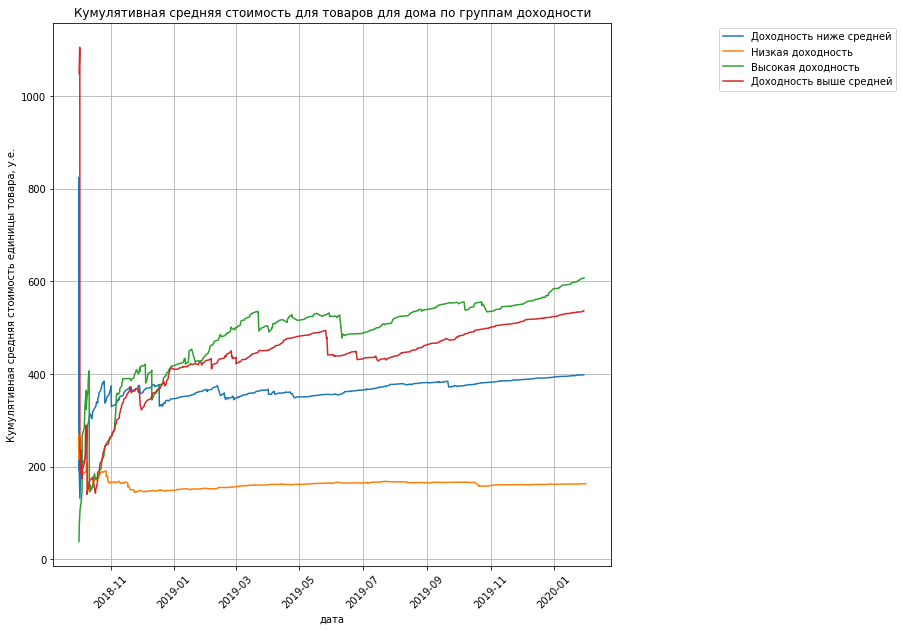

In [187]:
plot_dif_groups(all_for_home_cum, 'avg_price', 'revenue_group', 'date', 'Кумулятивная средняя стоимость для товаров для дома',
                'доходности', 'Кумулятивная средняя стоимость единицы товара, у.е.')

У категорий "Доходность выше средней" и "Доходность ниже средней" средняя стоимость товаров в начале рассматриваемого периода показала сильные всплески, которые связаны с малым количеством наблюдений, которое влияет на дисперсию среднего значения. Для более наглядного анализа построим график без учёта этих выбросов в начале периода.

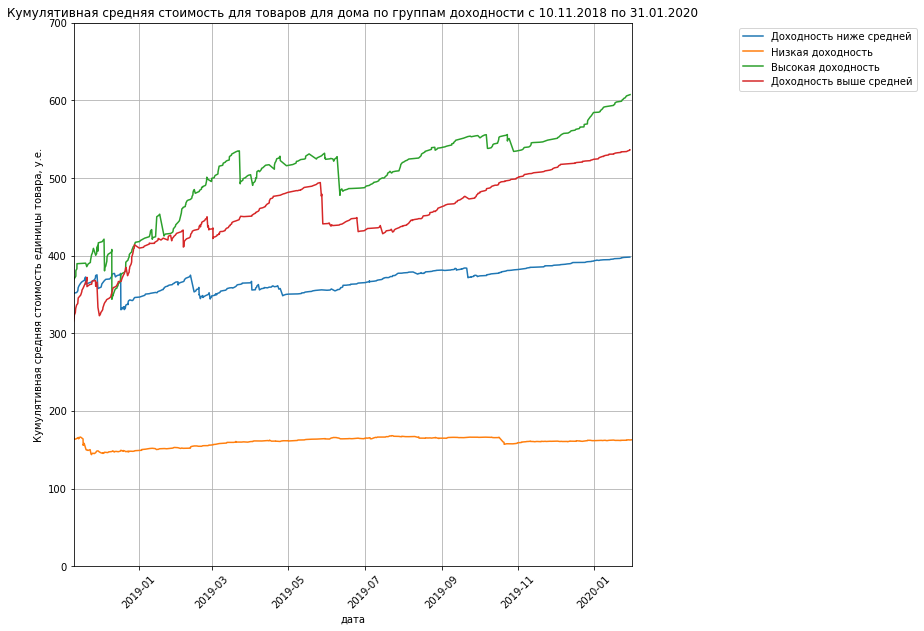

In [188]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set(title='Кумулятивная средняя стоимость для товаров для дома по группам доходности c 10.11.2018 по 31.01.2020', xlabel='дата',
       ylabel='Кумулятивная средняя стоимость единицы товара, у.е.')
for category in all_for_home_cum['revenue_group'].unique():
    df_categ = all_for_home_cum.query('revenue_group == @category')
    ax.plot(df_categ['date'], df_categ['avg_price'], '-', label=category)
xlabels = ax.xaxis.get_ticklabels()
for label in xlabels:
    label.set_rotation(45)
ax.grid()
ax.legend(bbox_to_anchor=(1.52, 1))
ax.axis([pd.to_datetime("2018-11-10"), pd.to_datetime('2020-01-31'), 0, 700])
plt.show()

На графике видно следующее:
* Кумулятивная средняя стоимость категории товаров "Высокая доходность" со временем растет;
* Кумулятивная средняя стоимость категорий товаров "Доходность выше средней" также растет со временем, но меньшими темпами;
* Кумулятивная средняя стоимость категорий товаров "Доходность ниже средней" также растет со временем, но еще меньшими темпами;
* Кумулятивная средняя стоимость категории товаров "Низкая доходность" на протяжении всего рассматриваемого периода остается примерно на одном и том же низком уровне.

# Категория "Цветы"

Построим кумулятивную таблицу для категории и рассчитаем среднюю стоимость товаров:

In [189]:
flowers_cum = df_addon_cum(flowers_goods, 'revenue_group')
flowers_cum['avg_price'] = flowers_cum['revenue'] / flowers_cum['quantity']

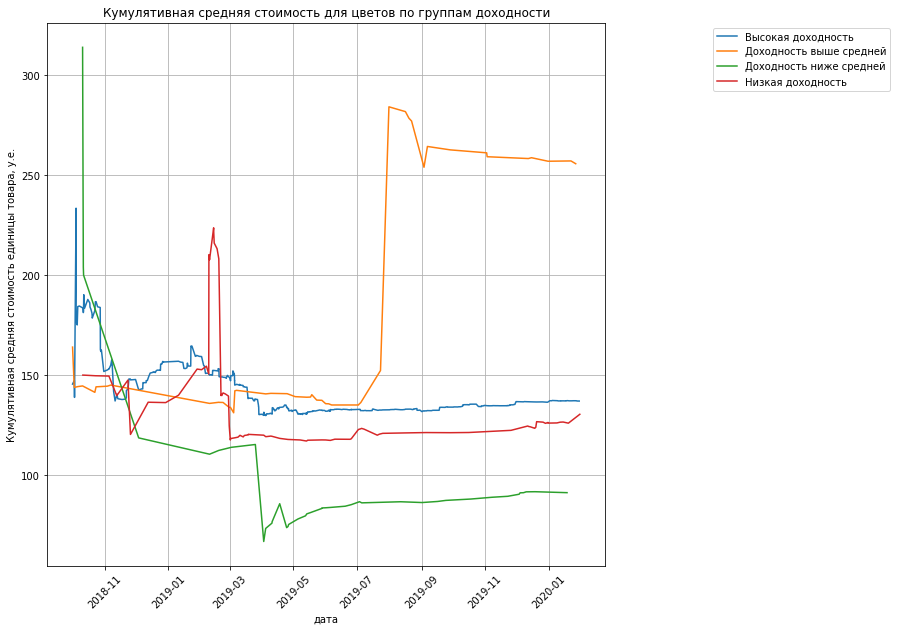

In [190]:
plot_dif_groups(flowers_cum, 'avg_price', 'revenue_group', 'date', 'Кумулятивная средняя стоимость для цветов',
                'доходности', 'Кумулятивная средняя стоимость единицы товара, у.е.')

У категорий "Высокая доходность" и "Доходность ниже средней" средняя стоимость товаров в начале рассматриваемого периода показала сильные всплески, которые связаны с малым количеством наблюдений, которое влияет на дисперсию среднего значения. Для более наглядного анализа построим график без учёта этих выбросов в начале периода.

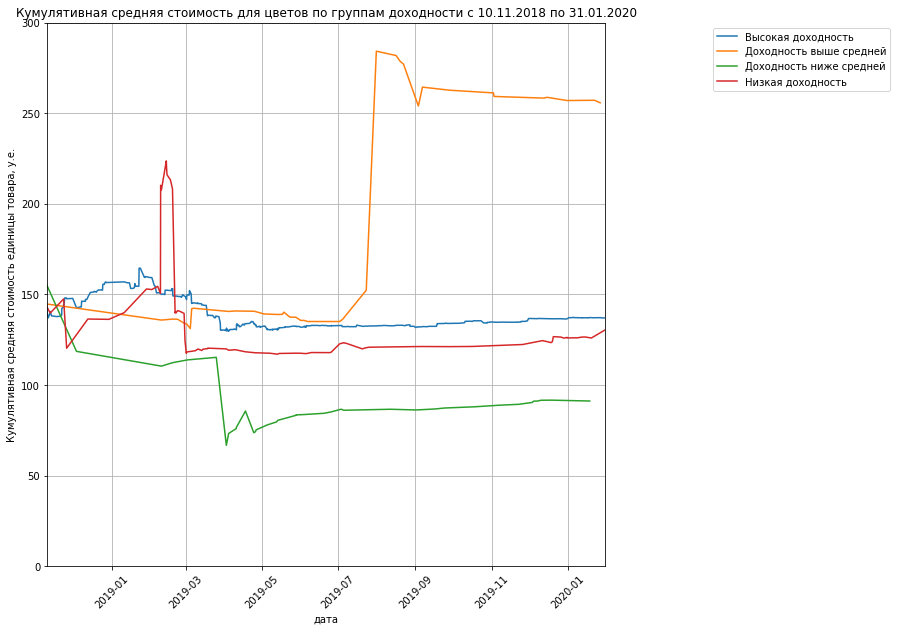

In [191]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set(title='Кумулятивная средняя стоимость для цветов по группам доходности c 10.11.2018 по 31.01.2020', xlabel='дата',
       ylabel='Кумулятивная средняя стоимость единицы товара, у.е.')
for category in flowers_cum['revenue_group'].unique():
    df_categ = flowers_cum.query('revenue_group == @category')
    ax.plot(df_categ['date'], df_categ['avg_price'], '-', label=category)
xlabels = ax.xaxis.get_ticklabels()
for label in xlabels:
    label.set_rotation(45)
ax.grid()
ax.legend(bbox_to_anchor=(1.52, 1))
ax.axis([pd.to_datetime("2018-11-10"), pd.to_datetime('2020-01-31'), 0, 300])
plt.show()

На графике видно следующее:

* Кумулятивная средняя стоимость категории товаров "Высокая доходность" за 4 месяца снижается и после марта находится примерно на одном и том же уровне;
* Кумулятивная средняя стоимость категории товаров "Доходность выше средней" находитяс на одном уровне до августа, после чего резко растет и на новом максимальном уровне среди других категорий находится до конца рассматриваемого периода;
* Кумулятивная средняя стоимость категории товаров "Доходность ниже средней" до апреля находится примерно на одном и том же уровне, после чего снижается и до конца рассматриваемого периода находится на этом самом низком среди других категорий уровне;
* Кумулятивная средняя стоимость категории товаров "Низкая доходность" имеем резкий всплеск в марте, все остальные месяцы находится примерно на одном и том же низком уровне.

# Категория "Семена и рассада"

Построим кумулятивную таблицу для категории и рассчитаем среднюю стоимость товара:

In [192]:
seeds_cum = df_addon_cum(seeds_goods, 'revenue_group')
seeds_cum['avg_price'] = seeds_cum['revenue'] / seeds_cum['quantity']

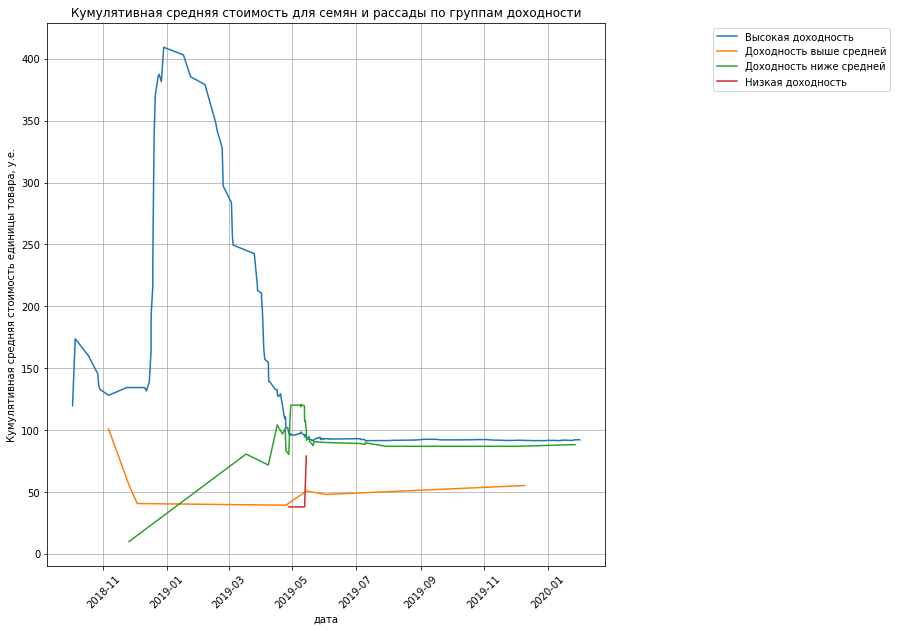

In [193]:
plot_dif_groups(seeds_cum, 'avg_price', 'revenue_group', 'date', 'Кумулятивная средняя стоимость для семян и рассады',
                'доходности', 'Кумулятивная средняя стоимость единицы товара, у.е.')

Здесь выбросов нет. На графике видно следующее:

* Кумулятивная средняя стоимость категории товаров "Высокая доходность" показывает очень высокие значения в период с января по май, что объясняется "высоким сезоном" для данного типа товаров. После мая этот показатель сравниваются с показателем кумулятивной средней стоимости категории товаров "Доходность ниже средней", у которой кумулятивная средняя стоимость до мая наоборот был низкий и к маю только и "подтянулся";
* Кумулятивная средняя стоимость категории товаров "Доходность выше средней" в декабре 2018 показывала падение после ноября, потом находилась на стабильно низком уровне до конца рассматриваемого периода;
* Кумулятивная средняя стоимость категории товаров "Низкая доходность" на графике присутствует только в июне и имеет низкие показатели, т.к. продаж в этой категории товаров было совсем мало.

# Категория "Все для кухни"

Построим кумулятивную таблицу для категории и рассчитаем среднюю стоимость:

In [194]:
all_for_kitchen_cum = df_addon_cum(all_for_kitchen_goods, 'revenue_group')
all_for_kitchen_cum['avg_price'] = all_for_kitchen_cum['revenue'] / all_for_kitchen_cum['quantity']

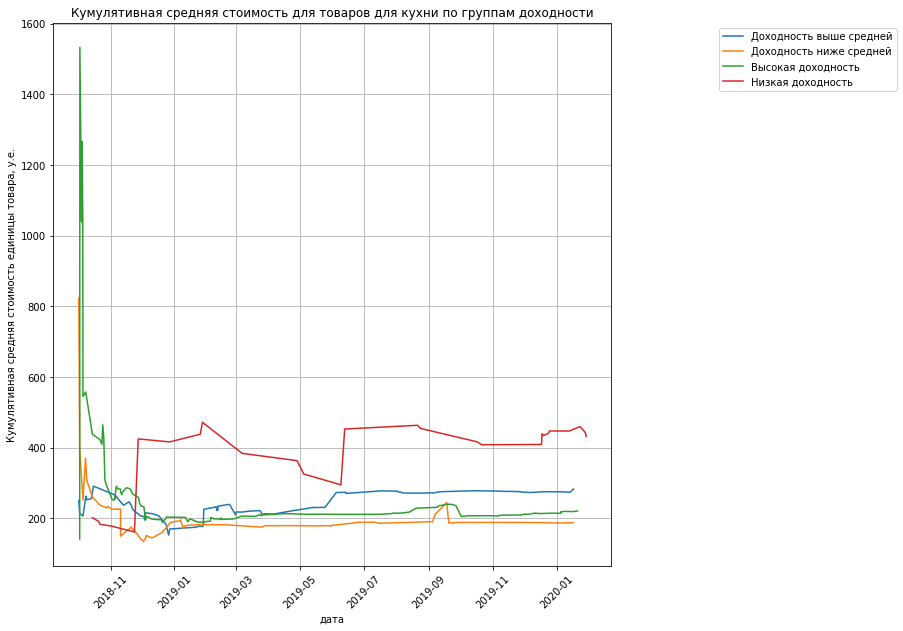

In [195]:
plot_dif_groups(all_for_kitchen_cum, 'avg_price', 'revenue_group', 'date', 'Кумулятивная средняя стоимость для товаров для кухни',
                'доходности', 'Кумулятивная средняя стоимость единицы товара, у.е.')

У категории "Высокая доходность" средняя стоимость в начале рассматриваемого периода показала сильные всплески, которые связаны с малым количеством наблюдений, которое влияет на дисперсию среднего значения. Для более наглядного анализа построим график без учёта этих выбросов в начале периода.

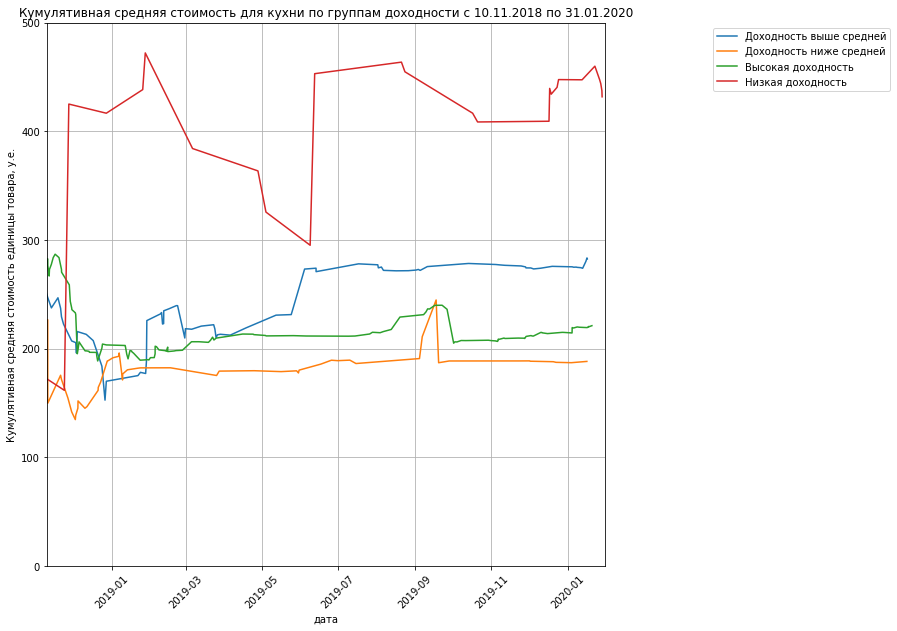

In [196]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set(title='Кумулятивная средняя стоимость для кухни по группам доходности c 10.11.2018 по 31.01.2020', xlabel='дата',
       ylabel='Кумулятивная средняя стоимость единицы товара, у.е.')
for category in all_for_kitchen_cum['revenue_group'].unique():
    df_categ = all_for_kitchen_cum.query('revenue_group == @category')
    ax.plot(df_categ['date'], df_categ['avg_price'], '-', label=category)
xlabels = ax.xaxis.get_ticklabels()
for label in xlabels:
    label.set_rotation(45)
ax.grid()
ax.legend(bbox_to_anchor=(1.52, 1))
ax.axis([pd.to_datetime("2018-11-10"), pd.to_datetime('2020-01-31'), 0, 500])
plt.show()

На графике видно следующее:

* Кумулятивная средняя стоимость категории товаров "Низкая доходность" резко растет в конце 2018 года, после чего находится все время выше показателей других категорий. Есть спад с февраля по июнь, но в этот период все равно кумулятивная средняя стоимость все равно выше, чем у конкурентов. После июня снова идет резкий рост показателя;
* Кумулятивная средняя стоимость категории товаров "Доходность ниже средней" после небольшого роста в начале на протяжении всего рассматриваемого периода находится примерно на одном уровне, который все время ниже, чем у конкурентов;
* Кумулятивная средняя стоимость категории товаров "Доходность выше средней" после небольшого снижения в начале стабильно растет до июня, после этого на протяжении всего рассматриваемого периода находится на стабильном уровне 2-го места среди других категорий;
* Кумулятивная средняя стоимость категории товаров "Высокая доходность" после небольшого спада в первый месяц находится примерно на одном уровне на протяжении всего рассматриваемого периода.

# Категория "Муляжи и искусственные растения"

Построим кумулятивную таблицу для категории и рассчитаем среднюю стоимость товара:

In [197]:
dummy_cum = df_addon_cum(dummy_goods, 'revenue_group')
dummy_cum['avg_price'] = dummy_cum['revenue'] / dummy_cum['quantity']

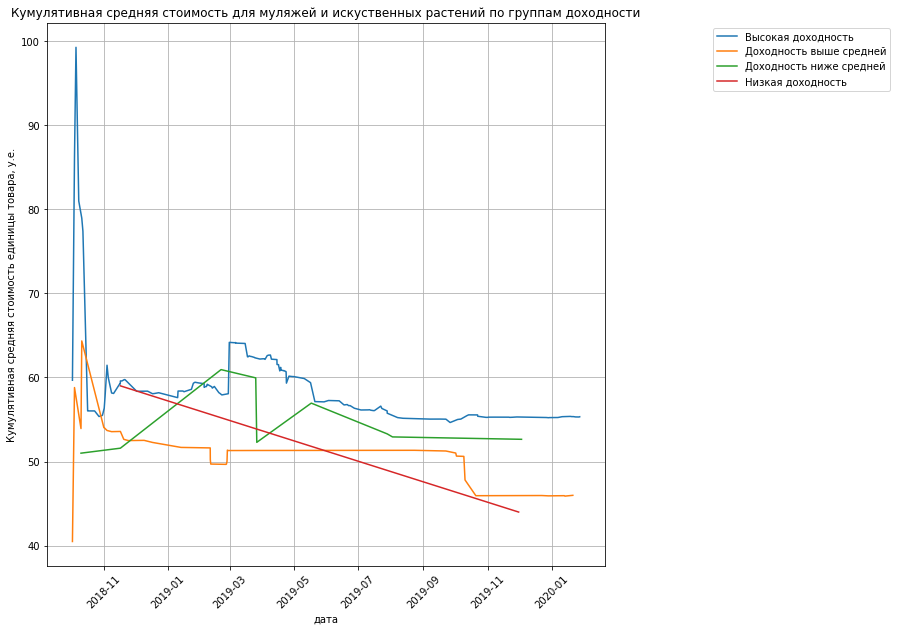

In [198]:
plot_dif_groups(dummy_cum, 'avg_price', 'revenue_group', 'date', 'Кумулятивная средняя стоимость для муляжей и искуственных растений',
                'доходности', 'Кумулятивная средняя стоимость единицы товара, у.е.')

У категорий "Высокая доходность" средняя стоимость в начале рассматриваемого периода показала сильные всплески, которые связаны с малым количеством наблюдений, которое влияет на дисперсию среднего значения. Для более наглядного анализа построим график без учёта этих выбросов в начале периода.

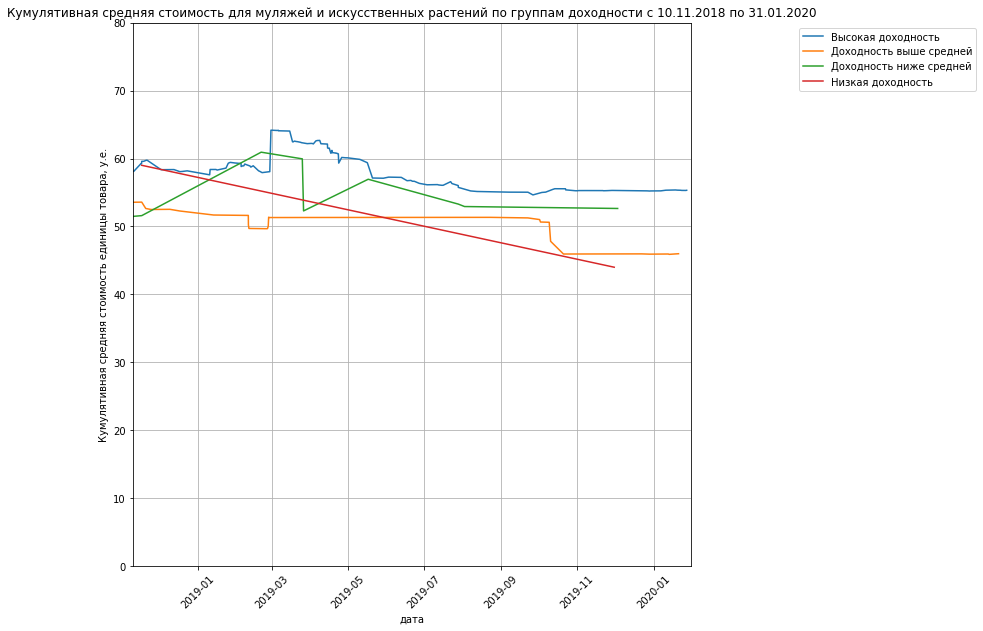

In [199]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set(title='Кумулятивная средняя стоимость для муляжей и искусственных растений по группам доходности c 10.11.2018 по 31.01.2020', xlabel='дата',
       ylabel='Кумулятивная средняя стоимость единицы товара, у.е.')
for category in dummy_cum['revenue_group'].unique():
    df_categ = dummy_cum.query('revenue_group == @category')
    ax.plot(df_categ['date'], df_categ['avg_price'], '-', label=category)
xlabels = ax.xaxis.get_ticklabels()
for label in xlabels:
    label.set_rotation(45)
ax.grid()
ax.legend(bbox_to_anchor=(1.52, 1))
ax.axis([pd.to_datetime("2018-11-10"), pd.to_datetime('2020-01-31'), 0, 80])
plt.show()

На графике видно следующее:

* Кумулятивная средняя стоимость категории товаров "Доходность выше средней" находится примерно на одном уровне на протяжении всего рассматриваемого периода, несколько снижаясь после октября;
* Кумулятивная средняя стоимость категории товаров "Высокая доходность" также находится примерно на одном уровне на протяжении всего рассматриваемого периода за исключением марта - мая, когда есть небольшой всплеск. При этом почти все время по данному показателю категория лидирует;
* Кумулятивная средняя стоимость категории товаров "Доходность ниже средней" после роста в начале постепенно снижается и выходит на стабильный средний уровень. Последние 2 месяца по категории нет данных, поэтому ее график неполный;
* Кумулятивная средняя стоимость категории товаров "Низкая доходность" стабильно снижается на протяжении всего рассматриваемого периода. Последние 2 месяца по категории нет данных, поэтому ее график неполный.

# Выводы по Сегментации товаров

1. Изучили 5 товарных категорий, на которые приходится подавляющее большинство (98%) продаж:
* Все для дома;
* Цветы;
* Семена и рассада;
* Все для кухни;
* Муляжи и искусственные растения.

2. Разделили товары внутри каждой категории на 4 группы в зависимости от выручки, которую они приносят магазину, исходя из расчитанных значений квантилей:
* "Низкая доходность";
* "Доходность ниже средней";
* "Доходность выше средней";
* "Высокая доходность".

3. У категории "Все для дома" получились такие показатели:

Примерно одинаково много заказов было по 3 группам:
* "Высокая доходность" (482 штуки);
* "Доходность выше средней" (500 штук);
* "Доходность ниже средней" (498 штук).

Меньше всего заказов было по группе "Низкая доходность" (458 штук).

Число покупателей также было наибольшим у тех же 3 групп:
* "Высокая доходность" (413 человек);
* "Доходность выше средней" (449 человека);
* "Доходность ниже средней" (447 человек).

Меньше всего покупателей было по группе "Низкая доходность" (403 человека).

4. У категории "Цветы" получились такие показатели:
* Лидер с огромным отрывом по числу заказов (762 штуки) и по числу покупателей (670 человек) - группа "Высокая доходность".
* Меньше всего заказов (43 штуки) и покупателей (43 человека) у группы "Доходность ниже средней".

5. У категории "Семена и рассада" получились такие показатели:
* Лидер с огромным отрывом по числу заказов (256 штук) и по числу покупателей (236 человек) - группа "Высокая доходность".
* Меньше всего заказов (4 штуки) и покупателей (4 человека) у группы "Доходность ниже средней".

6. У категории "Все для кухни" получились такие показатели:
* Лидер с большим отрывом по числу заказов (154 штуки) и по числу покупателей (142 человека) - группа "Высокая доходность".
* Меньше всего заказов (29 штук) и покупателей (29 человек) у группы "Доходность ниже средней".

7. У категории "Муляжи и искусственные растения" получились такие показатели:
* Лидер с огромным отрывом по числу заказов (164 штуки) и по числу покупателей (156 человек) - группа "Высокая доходность".
* Меньше всего заказов (2 штуки) и покупателей (2 человека) у группы "Доходность ниже средней".

8. Изучили кумулятивный средний чек по 4 подгруппам каждой из товарных групп:

А) У категории "Все для дома" график показал следующее:
* Кумулятивная средняя стоимость категории товаров "Высокая доходность" со временем растет;
* Кумулятивная средняя стоимость категорий товаров "Доходность выше средней" также растет со временем, но меньшими темпами;
* Кумулятивная средняя стоимость категорий товаров "Доходность ниже средней" также растет со временем, но еще меньшими темпами;
* Кумулятивная средняя стоимость категории товаров "Низкая доходность" на протяжении всего рассматриваемого периода остается примерно на одном и том же низком уровне.

Б) У категории "Цветы" график показал следующее:
* Кумулятивная средняя стоимость категории товаров "Высокая доходность" за 4 месяца снижается и после марта находится примерно на одном и том же уровне;
* Кумулятивная средняя стоимость категории товаров "Доходность выше средней" находитяс на одном уровне до августа, после чего резко растет и на новом максимальном уровне среди других категорий находится до конца рассматриваемого периода;
* Кумулятивная средняя стоимость категории товаров "Доходность ниже средней" до апреля находится примерно на одном и том же уровне, после чего снижается и до конца рассматриваемого периода находится на этом самом низком среди других категорий уровне;
* Кумулятивная средняя стоимость категории товаров "Низкая доходность" имеем резкий всплеск в марте, все остальные месяцы находится примерно на одном и том же низком уровне.

В) У категории "Семена и рассада" график показал следующее:
* Кумулятивная средняя стоимость категории товаров "Высокая доходность" показывает очень высокие значения в период с января по май, что объясняется "высоким сезоном" для данного типа товаров. После мая этот показатель сравниваются с показателем кумулятивной средней стоимости категории товаров "Доходность ниже средней", у которой кумулятивная средняя стоимость до мая наоборот был низкий и к маю только и "подтянулся";
* Кумулятивная средняя стоимость категории товаров "Доходность выше средней" в декабре 2018 показывала падение после ноября, потом находилась на стабильно низком уровне до конца рассматриваемого периода;
* Кумулятивная средняя стоимость категории товаров "Низкая доходность" на графике присутствует только в июне и имеет низкие показатели, т.к. продаж в этой категории товаров было совсем мало.

Г) У категории "Все для кухни" график показал следующее:
* Кумулятивная средняя стоимость категории товаров "Низкая доходность" резко растет в конце 2018 года, после чего находится все время выше показателей других категорий. Есть спад с февраля по июнь, но в этот период все равно кумулятивная средняя стоимость все равно выше, чем у конкурентов. После июня снова идет резкий рост показателя;
* Кумулятивная средняя стоимость категории товаров "Доходность ниже средней" после небольшого роста в начале на протяжении всего рассматриваемого периода находится примерно на одном уровне, который все время ниже, чем у конкурентов;
* Кумулятивная средняя стоимость категории товаров "Доходность выше средней" после небольшого снижения в начале стабильно растет до июня, после этого на протяжении всего рассматриваемого периода находится на стабильном уровне 2-го места среди других категорий;
* Кумулятивная средняя стоимость категории товаров "Высокая доходность" после небольшого спада в первый месяц находится примерно на одном уровне на протяжении всего рассматриваемого периода.

Д) У категории "Муляжи и искусственные растения" график показал следующее:
* Кумулятивная средняя стоимость категории товаров "Доходность выше средней" находится примерно на одном уровне на протяжении всего рассматриваемого периода, несколько снижаясь после октября;
* Кумулятивная средняя стоимость категории товаров "Высокая доходность" также находится примерно на одном уровне на протяжении всего рассматриваемого периода за исключением марта - мая, когда есть небольшой всплеск. При этом почти все время по данному показателю категория лидирует;
* Кумулятивная средняя стоимость категории товаров "Доходность ниже средней" после роста в начале постепенно снижается и выходит на стабильный средний уровень. Последние 2 месяца по категории нет данных, поэтому ее график неполный;
* Кумулятивная средняя стоимость категории товаров "Низкая доходность" стабильно снижается на протяжении всего рассматриваемого периода. Последние 2 месяца по категории нет данных, поэтому ее график неполный.

# Сегментация покупателей

In [200]:
df_addon_segm_copy = df_addon.copy(deep=True)
df_addon_segm_copy.loc[:, 'test_column'] = 1
df_addon_segm = df_addon_segm_copy.pivot_table(index = 'customer_id', columns = 'product_kategor', values='test_column', aggfunc='mean')\
.reset_index().fillna(0)

Разделим данные на признаки (матрица X) и целевую переменную (y):

In [201]:
X = df_addon_segm.drop('customer_id', axis=1)
y = df_addon_segm['customer_id']

Разделим модель на обучающую и валидационную выборку:

In [202]:
RANDOM_SEED = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = RANDOM_SEED)

In [203]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# строим матрицы расстояний
linked = linkage(X_sc, method = 'ward')

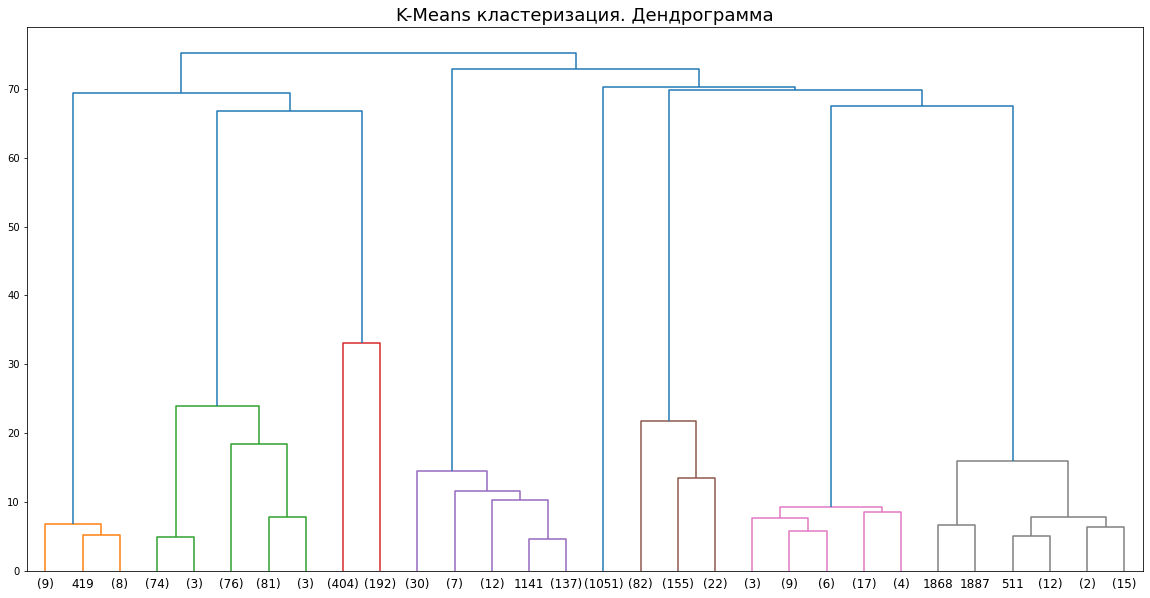

In [204]:
plt.figure(figsize=(20, 10))  
dendrogram(linked, orientation='top',
           truncate_mode='lastp',  # show only the last p merged clusters
           p=30,  # show only the last p merged clusters
           leaf_rotation=0,
           leaf_font_size=12)     
plt.title('K-Means кластеризация. Дендрограмма', size=18)
plt.show() 

На основании дендограммы выделим 8 кластеров: столько же, сколько категорий товаров (включая категорию "Другое").

In [205]:
km = KMeans(n_clusters = 8, random_state=RANDOM_SEED, n_jobs=1) # задаём число кластеров, равное 8
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров

Сохраним метки кластеров в поле датасета:

In [206]:
df_addon_segm['segm_km'] = labels

In [207]:
segments = df_addon_segm.groupby('segm_km').mean().T.iloc[:8]

Визуализируем результат:

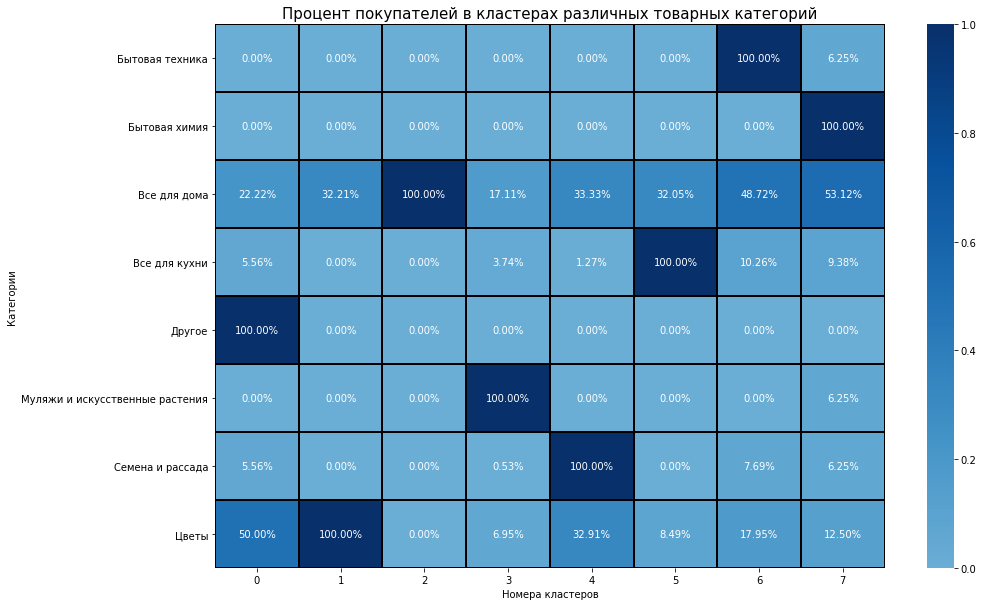

In [208]:
plt.figure(figsize = (15, 10))
plt.title('Процент покупателей в кластерах различных товарных категорий', size = 15)
sns_plot = sns.heatmap(segments, annot=True, fmt='.2%', 
                      linewidth=1, linecolor='black', vmax=1, center=0, cmap='Blues')
fig = sns_plot.get_figure()
plt.xlabel('Номера кластеров')
plt.ylabel('Категории')
plt.show()

Для каждого кластера характерна определенная категория товаров. Присвоим каждому кластеру свою товарную категорию:

In [209]:
segm_cat = pd.DataFrame()
categories = ['Все для дома', 'Цветы', 'Семена и рассада', 'Бытовая техника', 'Бытовая химия',  'Муляжи и искусственные растения', 'Все для кухни', 'Другое']
for i, product_kategor in zip(range(0,8), categories):
    segm_cat.loc[i, 'product_kategor'] = product_kategor
segm_cat = segm_cat.reset_index()
segm_cat.columns = ['segm_km', 'product_kategor']
segm_cat

,segm_km,product_kategor
0,0,Все для дома
1,1,Цветы
2,2,Семена и рассада
3,3,Бытовая техника
4,4,Бытовая химия
5,5,Муляжи и искусственные растения
6,6,Все для кухни
7,7,Другое


Вышло 8 кластеров, для каждого из которых характерна определенная категория товаров. Это значит, что каждый покупатель одного кластера хотя бы 1 раз купил товар данной категории.

Сравним поведение покупателей из разных кластеров после сегментации. Соединим первоначальный датасет с датасетом с кластерами по столбцу "customer_id":

In [210]:
df_addon = df_addon.merge(df_addon_segm, left_on='customer_id', right_on='customer_id')

Сгруппируем полученную таблицу по кластерам и найдем следующие метрики:
* среднее количество заказов;
* среднее количество купленных товаров на одного покупателя;
* средний чек;
* итоговую выручку.

In [211]:
orders_filt_segm = df_addon.groupby('segm_km')\
.agg({'customer_id':'nunique', 'order_id':'nunique', 'product':'count', 'quantity':'sum', 'price':'mean', 
      'revenue':'sum'})\
.reset_index().rename(columns={'customer_id':'n_buyers', 'order_id':'cnt_orders', 'product':'cnt_products_in_order', 
                               'quantity':'cnt_goods_in_order','price':'avg_price'})

In [212]:
orders_filt_segm['avg_orders_per_buyer'] = round(orders_filt_segm['cnt_orders']/orders_filt_segm['n_buyers'],0)
orders_filt_segm['avg_bill'] = orders_filt_segm['revenue'] / orders_filt_segm['cnt_orders']
orders_filt_segm['avg_goods_per_buyer'] = round(orders_filt_segm['cnt_goods_in_order'] / orders_filt_segm['n_buyers'], 0)

Построим графики этих метрик:

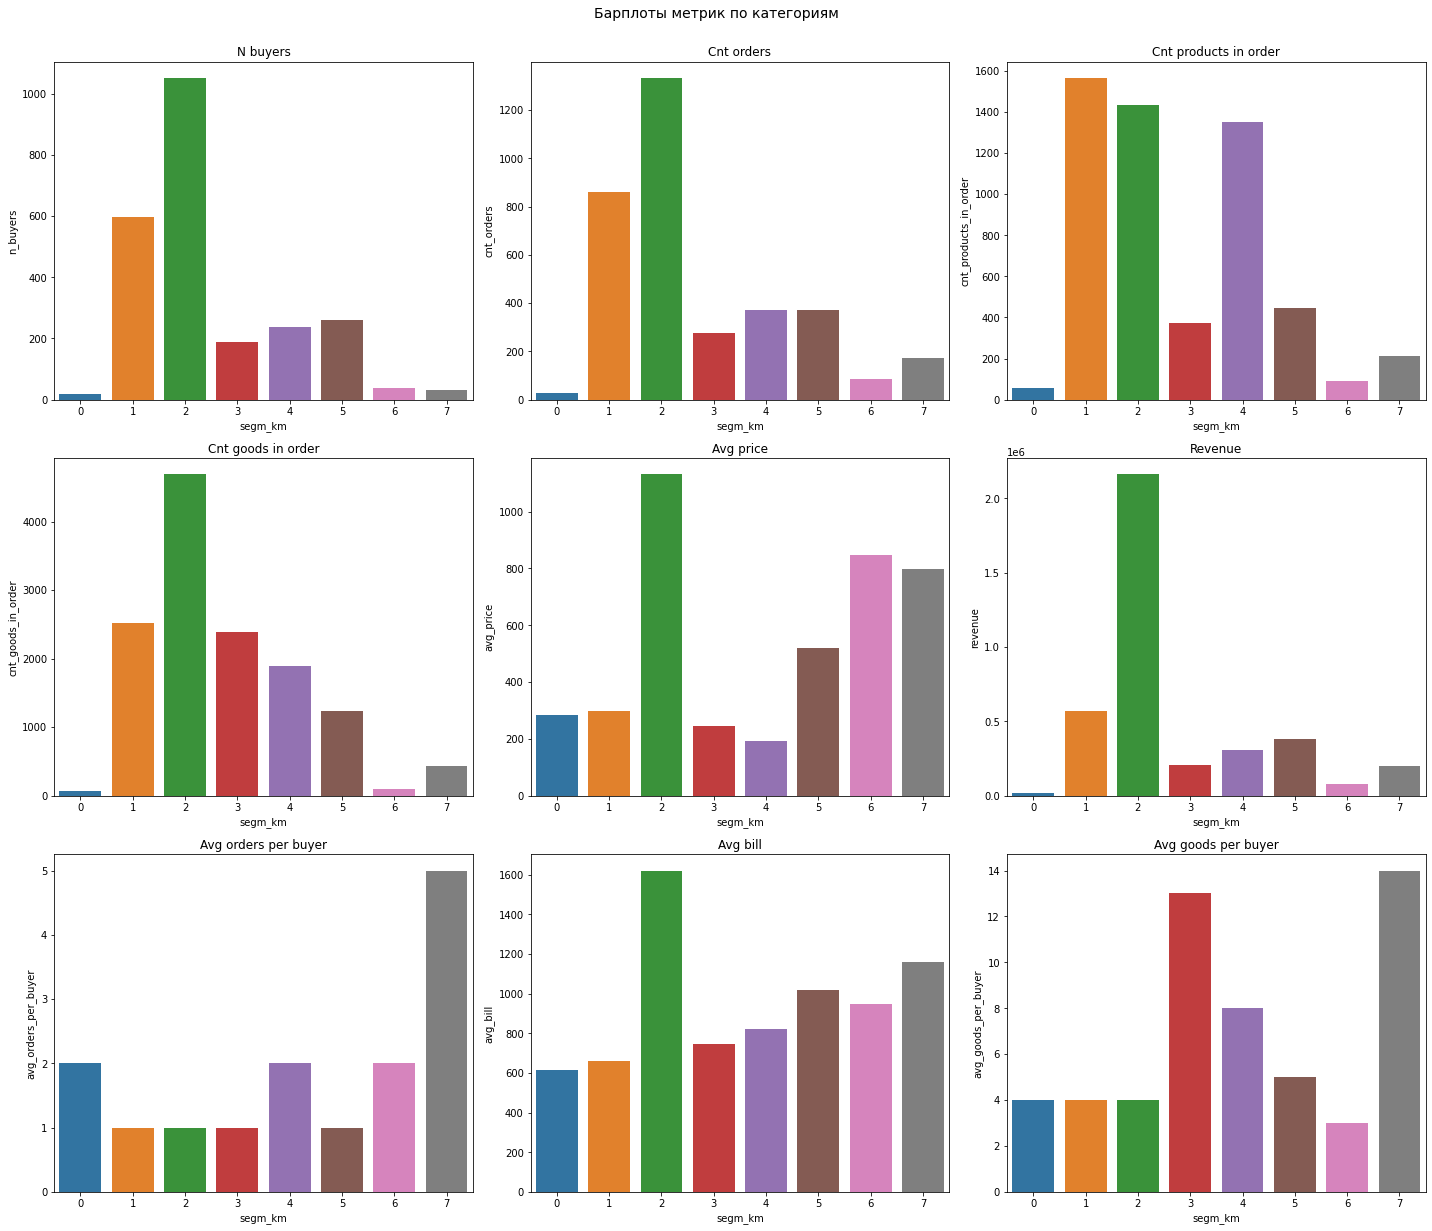

In [213]:
WIDTH = 3
plot_amount = len(orders_filt_segm.columns)
height = plot_amount//WIDTH

fig, axs = plt.subplots(height, WIDTH, figsize=(20, 17))
fig.suptitle('Барплоты метрик по категориям',  y=1.003, size=14)

for item, ax in zip(orders_filt_segm.columns[1:], np.ravel(axs)):
    sns.barplot(data = orders_filt_segm, x='segm_km', y=item, ax=ax)
    ax.set_title(item.capitalize().replace('_', ' '), size=12)

plt.tight_layout()
plt.show()

Посмотрим, какие кластеры лидируют по каким метрикам:

Кластер-2 ("Семена и рассада"):
* ТОП-1 по числу покупателей (‘n_buyers’);
* ТОП-1 по кол-ву заказов (‘cnt_orders’);
* ТОП-2 по среднему кол-ву товаров в заказе (‘cnt_products_in_order’);
* ТОП-1 по кол-ву купленных товаров (‘cnt_goods_in_order’);
* ТОП-1 по средней цене товара (‘avg_price’);
* ТОП-1 по выручке (‘revenue’);
* По среднему кол-ву проданных заказов на покупателя (‘avg_orders_per_buyer’) показатели слабые;
* ТОП по среднему чеку (‘avg_bill’);
* По среднему кол-ву проданных товаров на покупателя (‘avg_orders_per_buyer’) показатели слабые.

Кластер-1 ("Цветы"):
* ТОП-2 по числу покупателей (‘n_buyers’);
* ТОП-2 по кол-ву заказов (‘cnt_orders’);
* ТОП-1 по среднему кол-ву товаров в заказе (‘cnt_products_in_order’);
* ТОП-2 по кол-ву купленных товаров (‘cnt_goods_in_order’);
* По средней цене товара (‘avg_price’) показатели слабые;
* ТОП-2 по выручке (‘revenue’);
* По среднему кол-ву проданных заказов на покупателя (‘avg_orders_per_buyer’) показатели слабые;
* По среднему чеку (‘avg_bill’) показатели слабые;
* По среднему кол-ву проданных товаров на покупателя (‘avg_orders_per_buyer’) показатели слабые.

Кластер-5 ("Муляжи и искусственные растения"):
* ТОП-3 по числу покупателей (‘n_buyers’);
* ТОП-3 по кол-ву заказов (‘cnt_orders’);
* ТОП-4 по среднему кол-ву товаров в заказе (‘cnt_products_in_order’);
* ТОП-5 по кол-ву купленных товаров (‘cnt_goods_in_order’);
* ТОП-4 по средней цене товара (‘avg_price’);
* ТОП-3 по выручке (‘revenue’);
* По среднему кол-ву проданных заказов на покупателя (‘avg_orders_per_buyer’) показатели слабые;
* ТОП-3 по среднему чеку (‘avg_bill’);
* ТОП-4 по среднему кол-ву проданных товаров на покупателя (‘avg_orders_per_buyer’).

Кластер-4 ("Бытовая химия"):
* ТОП-4 по числу покупателей (‘n_buyers’);
* ТОП-3 по кол-ву заказов (‘cnt_orders’);
* ТОП-3 по среднему кол-ву товаров в заказе (‘cnt_products_in_order’);
* ТОП-3 по кол-ву купленных товаров (‘cnt_goods_in_order’);
* По средней цене товара (‘avg_price’) показатели слабые;
* ТОП-4 по выручке (‘revenue’);
* ТОП-3 по среднему кол-ву проданных заказов на покупателя (‘avg_orders_per_buyer’);
* ТОП-5 по среднему чеку (‘avg_bill’);
* ТОП-4 по среднему кол-ву проданных товаров на покупателя (‘avg_orders_per_buyer’).

Кластер-3 ("Бытовая техника"):
* ТОП-5 по числу покупателей (‘n_buyers’);
* ТОП-5 по кол-ву заказов (‘cnt_orders’);
* ТОП-5 по среднему кол-ву товаров в заказе (‘cnt_products_in_order’);
* ТОП-3 по кол-ву купленных товаров (‘cnt_goods_in_order’);
* По средней цене товара (‘avg_price’) показатели слабые;
* ТОП-5 по выручке (‘revenue’);
* По среднему кол-ву проданных заказов на покупателя (‘avg_orders_per_buyer’) показатели слабые;
* ТОП-6 по среднему чеку (‘avg_bill’);
* ТОП-2 по среднему кол-ву проданных товаров на покупателя (‘avg_orders_per_buyer’).

Остальные кластеры отстают по своим показателям от перечисленных выше.

# TF-IDF эксперимент

Сегментируем датафрейм, используя tf-idf меру для оценки важности названий товаров:

In [214]:
df_addon_tf_idf = df_addon.copy(deep=True)

In [215]:
# Преобразуем столбец product в вектор
tfidf_vectorizer = TfidfVectorizer()
tfidf_result = tfidf_vectorizer.fit_transform(df_addon_tf_idf['product'])

In [216]:
# Понизим размерность данных методом PCA (методом главных компонент)
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(tfidf_result.toarray())

In [217]:
# Применим алгоритм к данным и поделим датафрейм на 10 кластеров
cluster_labels = KMeans(n_clusters=10, random_state=RANDOM_SEED, n_jobs=1).fit_predict(data_reduced)

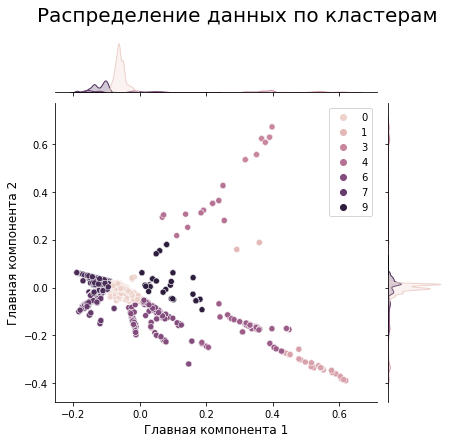

In [218]:
ax = sns.jointplot(x=data_reduced[:, 0], 
              y=data_reduced[:, 1], 
              hue=cluster_labels)
ax.fig.suptitle('Распределение данных по кластерам', size=20)
ax.fig.subplots_adjust(top=0.9)
ax.set_axis_labels('Главная компонента 1', 'Главная компонента 2', fontsize=12)
plt.show()

Поскольку компоненты PCA не имеют под собой экономического смысла, обозначим их как главная компонента 1 и главная компонента 2. Данные признаки являются проекцией многомерного пространства на плоскость с максимизацией сохраненной дисперсии первичного распределения.

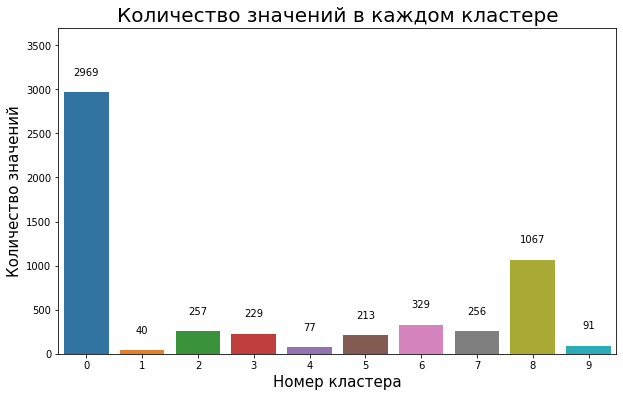

In [219]:
grouped_category = grouped_category.sort_values(by='revenue', ascending = False)
plt.figure(figsize=(10,6))
plt.title('Количество значений в каждом кластере', size=20)
ax = sns.countplot(x=cluster_labels);
for p in ax.patches:
        ax.annotate (str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
plt.xlabel('Номер кластера', size=15)
plt.ylabel('Количество значений', size=15)
plt.ylim(None, 3700)
plt.show()

По количеству значений очень выделяется нулевой кластер, в него попало много товаров, в то время как остальные кластеры сильно отстают по всем показателям. У ближайшего преследователя - 8-го кластера - почти в 3 раза меньше значений.

In [220]:
df_addon_tf_idf['pca_kmean'] = cluster_labels
df_addon_tf_idf_pca = df_addon_tf_idf.groupby('pca_kmean').agg({'quantity':'sum', 'price':'sum'}).reset_index()\
.rename(columns={'price':'revenue'})
df_addon_tf_idf_pca

,pca_kmean,quantity,revenue
0,0,9865,1.651848e+06
1,1,43,2.965000e+03
2,2,349,4.401900e+04
3,3,284,3.093633e+04
4,4,92,9.102000e+03
5,5,253,3.270900e+04
6,6,474,6.401650e+04
7,7,420,3.600250e+04
8,8,1428,1.046540e+06
9,9,120,1.468900e+04


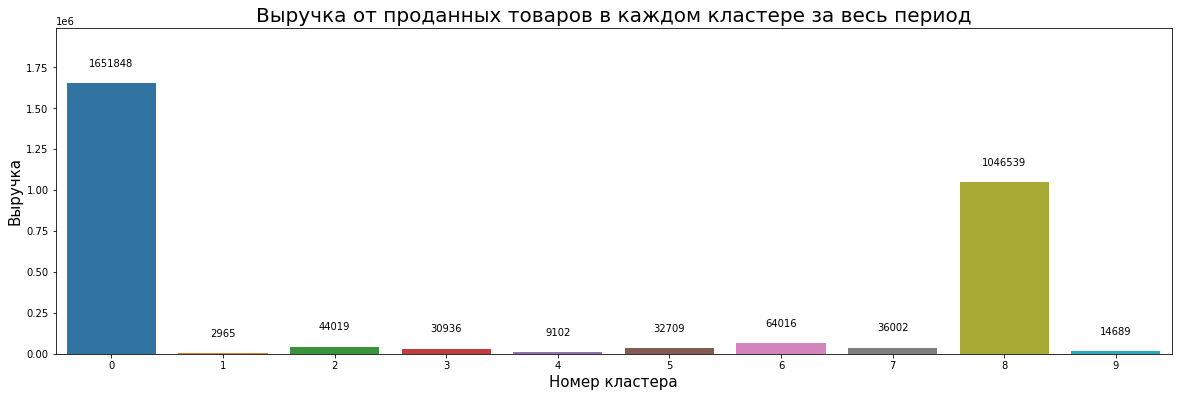

In [221]:
plt.figure(figsize=(20,6))
plt.title('Выручка от проданных товаров в каждом кластере за весь период', size=20)
ax = sns.barplot(y=df_addon_tf_idf_pca['revenue'], 
                 x=df_addon_tf_idf_pca['pca_kmean'])
for p in ax.patches:
        ax.annotate (str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
plt.xlabel('Номер кластера', size=15)
plt.ylabel('Выручка', size=15)
plt.ylim(None, 1.99e6)
plt.show()

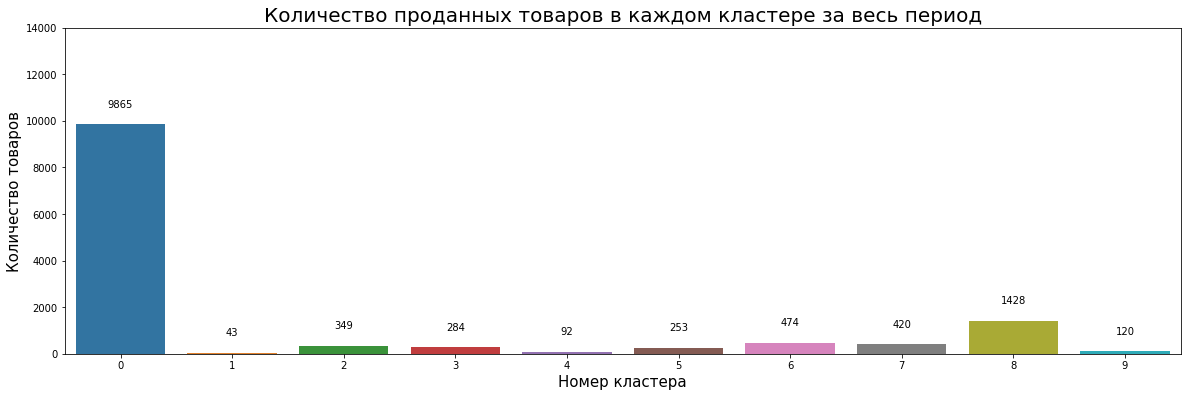

In [222]:
plt.figure(figsize=(20,6))
plt.title('Количество проданных товаров в каждом кластере за весь период', size=20)
ax = sns.barplot(y=df_addon_tf_idf_pca['quantity'], 
                 x=df_addon_tf_idf_pca['pca_kmean'])
for p in ax.patches:
        ax.annotate (str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
plt.xlabel('Номер кластера', size=15)
plt.ylabel('Количество товаров', size=15)
plt.ylim(None, 14000)
plt.show()

То же самое касается выручки и количества проданных товаров. Из-за большого размера нулевого кластера, данные распределены с явным перекосом, что делает невозможным дальнейший анализ данных. Получается, что разделение на кластеры данным способом некорректно. Для дальнейшей оценки придерживаемся способа из предыдущего шага.

# Проверка статистических гипотез

Сформулируем гипотезы и выделим 5 наиболее перспективных кластеров и посчитать статистическую значимость различий в среднем чеке заказа между группами:

Нулевая гипотеза H0: значимые различия между сравниваемыми выборками отсутствуют
Альтернативная гипотеза H1: значимые различия между сравниваемыми выборками есть

Критический уровень статистической значимости: Alpha = 0.05 В дальнейшем мы будем корректировать критический уровень статистической значимости используя поправку Шидака для случая множественной проверки гипотез.

Для большего удобства сгруппируем данные по кластерам и id пользователей для нахождения значимых различий в среднем чеке между выборками:

In [223]:
orders = df_addon.groupby(['customer_id', 'segm_km']).agg({'revenue':'sum'}).reset_index()

In [224]:
#Создадим лист с парами групп, для которых необходимо провести Тест Манна-Уитни
test_pairs_list = list(itertools.combinations([1, 2, 3, 4, 5], 2))
print(test_pairs_list)

[(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


In [225]:
p_data = []
for pair_names in test_pairs_list:
    group1 = pair_names[0]
    group2 = pair_names[1]
    pvals = (stats.mannwhitneyu(orders[orders['segm_km']==group1]['revenue'], 
                                orders[orders['segm_km']==group2]['revenue'], alternative='two-sided')[1])
    p_data.append(pvals)
    multitest_result = multipletests(p_data, 0.05, method='sidak')

In [226]:
for pair_names, test_status, corrected_p in zip(test_pairs_list, multitest_result[0], multitest_result[1]):
    print('Пара кластеров', pair_names)
    print('alpha с поправкой Шидака: ', multitest_result[2])
    if test_status:
        print('Отвергаем нулевую гипотезу: значимые различия между сравниваемыми выборками есть.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, значимые различия между сравниваемыми выборками отсутствуют.') 
    print('p-значение после корректировки: ', corrected_p)  
    print('Относительные различия в среднем чеке между группами: {0:.3f}'\
   .format(orders[orders['segm_km']==pair_names[0]]['revenue'].mean()/orders[orders['segm_km']==pair_names[1]]['revenue']\
           .mean()-1))
    print()

Пара кластеров (1, 2)
alpha с поправкой Шидака:  0.005116196891823743
Отвергаем нулевую гипотезу: значимые различия между сравниваемыми выборками есть.
p-значение после корректировки:  1.7517515622384457e-33
Относительные различия в среднем чеке между группами: -0.537

Пара кластеров (1, 3)
alpha с поправкой Шидака:  0.005116196891823743
Отвергаем нулевую гипотезу: значимые различия между сравниваемыми выборками есть.
p-значение после корректировки:  6.771495028810658e-07
Относительные различия в среднем чеке между группами: -0.135

Пара кластеров (1, 4)
alpha с поправкой Шидака:  0.005116196891823743
Отвергаем нулевую гипотезу: значимые различия между сравниваемыми выборками есть.
p-значение после корректировки:  0.00011871860672373076
Относительные различия в среднем чеке между группами: -0.263

Пара кластеров (1, 5)
alpha с поправкой Шидака:  0.005116196891823743
Отвергаем нулевую гипотезу: значимые различия между сравниваемыми выборками есть.
p-значение после корректировки:  0.0010

В результате проведения теста Манна-Уитни получили, что почти между всеми парами перспективных кластеров нулевые гипотезы отверглись, что означает: значимые различия в среднем чеке между сравниваемыми выборками есть, кроме пары кластеров 4 и 5 - "Бытовая химия" и "Муляжи и искусственные растения". Они приносят примерно равную прибыль, хоть и небольшую.

# Выводы по сегментации покупателей

1. Наиболее перспективные кластеры:

Кластер-2 ("Семена и рассада"):
* ТОП-1 по числу покупателей (‘n_buyers’);
* ТОП-1 по кол-ву заказов (‘cnt_orders’);
* ТОП-2 по среднему кол-ву товаров в заказе (‘cnt_products_in_order’);
* ТОП-1 по кол-ву купленных товаров (‘cnt_goods_in_order’);
* ТОП-1 по средней цене товара (‘avg_price’);
* ТОП-1 по выручке (‘revenue’);
* По среднему кол-ву проданных заказов на покупателя (‘avg_orders_per_buyer’) показатели слабые;
* ТОП по среднему чеку (‘avg_bill’);
* По среднему кол-ву проданных товаров на покупателя (‘avg_orders_per_buyer’) показатели слабые.

Кластер-1 ("Цветы"):
* ТОП-2 по числу покупателей (‘n_buyers’);
* ТОП-2 по кол-ву заказов (‘cnt_orders’);
* ТОП-1 по среднему кол-ву товаров в заказе (‘cnt_products_in_order’);
* ТОП-2 по кол-ву купленных товаров (‘cnt_goods_in_order’);
* По средней цене товара (‘avg_price’) показатели слабые;
* ТОП-2 по выручке (‘revenue’);
* По среднему кол-ву проданных заказов на покупателя (‘avg_orders_per_buyer’) показатели слабые;
* По среднему чеку (‘avg_bill’) показатели слабые;
* По среднему кол-ву проданных товаров на покупателя (‘avg_orders_per_buyer’) показатели слабые.

Кластер-5 ("Муляжи и искусственные растения"):
* ТОП-3 по числу покупателей (‘n_buyers’);
* ТОП-3 по кол-ву заказов (‘cnt_orders’);
* ТОП-4 по среднему кол-ву товаров в заказе (‘cnt_products_in_order’);
* ТОП-5 по кол-ву купленных товаров (‘cnt_goods_in_order’);
* ТОП-4 по средней цене товара (‘avg_price’);
* ТОП-3 по выручке (‘revenue’);
* По среднему кол-ву проданных заказов на покупателя (‘avg_orders_per_buyer’) показатели слабые;
* ТОП-3 по среднему чеку (‘avg_bill’);
* ТОП-4 по среднему кол-ву проданных товаров на покупателя (‘avg_orders_per_buyer’).

Кластер-4 ("Бытовая химия"):
* ТОП-4 по числу покупателей (‘n_buyers’);
* ТОП-3 по кол-ву заказов (‘cnt_orders’);
* ТОП-3 по среднему кол-ву товаров в заказе (‘cnt_products_in_order’);
* ТОП-3 по кол-ву купленных товаров (‘cnt_goods_in_order’);
* По средней цене товара (‘avg_price’) показатели слабые;
* ТОП-4 по выручке (‘revenue’);
* ТОП-3 по среднему кол-ву проданных заказов на покупателя (‘avg_orders_per_buyer’);
* ТОП-5 по среднему чеку (‘avg_bill’);
* ТОП-4 по среднему кол-ву проданных товаров на покупателя (‘avg_orders_per_buyer’).

Кластер-3 ("Бытовая техника"):
* ТОП-5 по числу покупателей (‘n_buyers’);
* ТОП-5 по кол-ву заказов (‘cnt_orders’);
* ТОП-5 по среднему кол-ву товаров в заказе (‘cnt_products_in_order’);
* ТОП-3 по кол-ву купленных товаров (‘cnt_goods_in_order’);
* По средней цене товара (‘avg_price’) показатели слабые;
* ТОП-5 по выручке (‘revenue’);
* По среднему кол-ву проданных заказов на покупателя (‘avg_orders_per_buyer’) показатели слабые;
* ТОП-6 по среднему чеку (‘avg_bill’);
* ТОП-2 по среднему кол-ву проданных товаров на покупателя (‘avg_orders_per_buyer’).

2. Попытка кластеризовать датафрейм, используя tf-idf меру для оценки важности названий продуктов не дала результата, т.к. после кластеризации из-за большого размера нулевого кластера, данные стали распределяться с явным перекосом, что сделало невозможным дальнейший анализ данных. Из этого был сделан вывод, что разделение на кластеры данным способом некорректно. Для дальнейшей оценки стал придерживаться способа из предыдущего шага.


3. В результате проведения теста Манна-Уитни получили, что почти между всеми парами перспективных кластеров нулевые гипотезы отверглись, что означает: значимые различия в среднем чеке между сравниваемыми выборками есть, кроме пары кластеров 4 и 5 -  "Бытовая химия" и "Муляжи и искусственные растения". Они приносят примерно равную прибыль, хоть и небольшую.

# Рекомендации

1. У магазина нет ярко выраженного сезона. Наиболее удачные месяцы у магазина с точки зрения числа заказов - это декабрь 2018 года, февраль-апрель 2019 года, а также ноябрь-январь 2019-2020 годов.


2. У магазина на протяжении года падает выручка, причем даже в сезон это падение не остановилось. Нужно проработать рекламную кампанию, акции и другие методы для повышения узнаваемости вашего бренда и привлечения покупателей в магазин.


3. Товары категорий "Все для дома" и "Все для кухни" имеют достаточно сильную корреляцию продаж. Это можно использовать при составлении акций, а также при товарной выкладке, располагая товары этих групп рядом в торговом зале. У товаров других категорий корреляции продаж нет.


4. Лучше всего продаются товары из категорий "Все для дома", "Цветы", "Семена и рассада". Нужно делать упор на них, расширяя номенклатуру данных разделов, предоставить им лучшие места для выкладки в торговом зале, разместить эти разделы на видном месте на сайте.


5. Товары из категорий "Бытовая техника" и "Бытовая химия" продаются слабо. Предлагаю рассмотреть вопрос о целесообразности торговли данными направлениями особенно с учетом отсутствия корреляции продаж товаров данных категорий с другими важными товарными категорями.


6. Больше всего дохода приносят такие позиции:
* "Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок" (53232 у.е.);
* "Сумка-тележка 2-х колесная Gimi Argo синяя" (50405);
* "Вешалки мягкие для деликатных вещей 3 шт шоколад" (49596 у.е.).
Их нужно разместить на видном месте в торговом зале, добавлять в акции, вывести их на главную страницу сайта, а также держать достаточный запас данных позиций на складе.
Также нужно акцентировать особое внимание на покупателях данных товаров, как на наиболее ценных для бизнеса.


7. Наибольший общий доход среди категорий товаров приносит категория "Все для дома" (75,5%). Соответственно, нужно расширять номенклатуру данной категории в торговом зале, расположить ее товары на самом видном месте, использовать это преимущество при составлении акций. На сайте этим товарам также должен быть отдан приоритет.
Также нужно акцентировать особое внимание на покупателях данной категории товаров, как на наиболее ценных для бизнеса.


8. Наибольший доход дают такие товары:
* Сумка-тележка 2-х колесная Gimi Argo синяя;
* Сумка-тележка 2-х колесная складная Gimi Flexi зеленая.
Их нужно разместить на видном месте в торговом зале, добавлять в акции, вывести их на главную страницу сайта, а также держать достаточный запас данных позиций на складе.
Они продаются сами по себе (без сопутствующих товаров), это нужно учитывать при составлении акций с их участием.
Также нужно акцентировать особое внимание на покупателях данных товаров, как на наиболее ценных для бизнеса.


9. Товары категорий "Все для дома", "Все для кухни" и "Муляжи и искусственные растения" чаще всего продаются без сопутствующих товаров из других категорий. А вот товары категорий "Семена и рассада" и "Цветы" часто являются в заказах сопутствующими. Это нужно учитывать при составлении акций с их участием.


10. Лучше продаются самые дорогие товары, а также товары среднего ценового сегмента: по ним больше как заказов, так и покупателей. Хуже всего продаются самые дешевые товары. Это касается 5 основных товарных групп. Поэтому расширение ассортимента нужно планировать в первую очередь за счет более дорогих товаров. Также в акциях нужно делать упор именно на таком ценовом сегменте.
Также нужно акцентировать особое внимание на покупателях товаров дорогого и среднего ценовых сегментов, как на наиболее ценных для бизнеса.


11. Поскольку большинство заказов включает всего 1 товар, необходимо мотивировать покупателей на добавление 2 и более товаров в заказ, давая скидку на второй товар, бонусы на следующую покупку и т.д.

Ссылка на презентацию: https://disk.yandex.ru/i/YO5g_0Du2Ezmsw